Import libraries

In [264]:
#%% 
import xarray as xr
from PyCO2SYS import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import pandas as pd

from cProfile import label
from json import load
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PyCO2SYS import sys
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore")

import warnings

# 3rd party libraries
import statsmodels.api as sm
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.feature as cfeature

from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import scipy

projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))

import cmasher as cmr



# Define maximum and minimum boundary

In [265]:
#%%
yr_min = 1993
yr_max = 2021+1
time_min = np.datetime64('1993-01-01')
time_max = np.datetime64('2021-12-31')
lon_min = -170
lon_max = -40
lat_min = 10
lat_max = 65
#%%
def calc_clim_anom(ts):
    ts_reshape = np.reshape(ts,[np.int64(len(ts)/12),12])
    ts_detrend = scipy.signal.detrend(ts,axis=0)
    ts_detrend_reshape = np.reshape(ts_detrend,ts_reshape.shape)
    clim = np.nanmean(ts_detrend_reshape,axis=0)
    ts_anom = ts_reshape - clim
    ts_anom = np.reshape(ts_anom,ts.shape)
    return clim,ts_anom
n_yr = np.int64(yr_max-yr_min)

## Define functions

In [266]:
def bin_counts(x,y,xlim,ylim,step):
    x_new = np.arange(xlim[0],xlim[1]+step/2,step)
    y_new = np.arange(ylim[0],ylim[1]+step/2,step)

    dens = np.full((len(y_new),len(x_new)),np.nan)
    for idxx in range(len(x_new)):
        for idxy in range(len(y_new)):
            n = np.sum((x>=x_new[idxx]-step/2) & (x<x_new[idxx]+step/2) & (y>=y_new[idxy]-step/2) & (y<y_new[idxy]+step/2))
            if n>0:
                dens[idxx,idxy] = np.copy(n)
    return dens,x_new,y_new

def calc_trend_Sutton(t, y, w):
    ivalid = ~np.isnan(t * y)
    lm_raw = sm.OLS(y[ivalid], sm.add_constant(t[ivalid])).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    ts_trend_remove = lm_raw.predict(sm.add_constant(t[ivalid]))
    ts_y_detrend = np.full_like(y,np.nan)
    ts_y_detrend[ivalid] = y[ivalid] - ts_trend_remove
    ts_y_month_clim = np.nanmean(np.reshape(ts_y_detrend,[-1,12]),axis=0)
    ts_y_annual_clim = np.nanmean(ts_y_month_clim)
    month_adj = ts_y_month_clim - ts_y_annual_clim
    ts_monthly_deseason = np.reshape(np.reshape(y,(-1,12)) - month_adj,len(y))
    # w = 1.0 / (5.0 * np.ones(len(y_adj_i)) ** 2)
    ivalid = ~np.isnan(ts_monthly_deseason)
    lm_wls = sm.WLS(ts_monthly_deseason[ivalid],sm.add_constant(t[ivalid]), w).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    
    trend_dict = {}
    trend_dict['model'] = lm_wls 
    trend_dict['monthly_clim'] = ts_y_month_clim
    trend_dict['annual_clim'] = ts_y_annual_clim
    trend_dict['ts_monthly_deseason'] = ts_monthly_deseason
    return trend_dict

def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Calculate R² and RMSE between two arrays, handling NaN values.
    
    Parameters:
    -----------
    y_true : np.ndarray
        True/observed values
    y_pred : np.ndarray
        Predicted/estimated values
    
    Returns:
    --------
    r2 : float
        R-squared (coefficient of determination)
    rmse : float
        Root Mean Square Error
    """
    # Remove pairs where either value is NaN
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        return np.nan, np.nan
    
    # Calculate R²
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    return r2, rmse

# Read data
## SOCAT

In [267]:
file_socat = '/Volumes/Crucial_4T/carbon/SOCAT/v2023/SOCATv2023_qrtrdeg_gridded_coast_monthly.nc'
ds_socat = xr.open_dataset(file_socat)
lon_socat = ds_socat.xlon.values
lat_socat = ds_socat.ylat.values
time_socat = ds_socat.tmnth.values
idxx = np.where((lon_socat>=lon_min) & (lon_socat<=lon_max))[0]
idxy = np.where((lat_socat>=lat_min) & (lat_socat<=lat_max))[0]
idxt = np.where((time_socat>=time_min) & (time_socat<=time_max))[0]
lon_socat = lon_socat[idxx]
lat_socat = lat_socat[idxy]
time_socat = time_socat[idxt]
fco2_socat = ds_socat.coast_fco2_ave_weighted[idxt,idxy,idxx].values
sst_socat = ds_socat.coast_sst_ave_weighted[idxt,idxy,idxx].values
sss_socat = ds_socat.coast_salinity_ave_weighted[idxt,idxy,idxx].values
fco2_socat[(fco2_socat>1000)|(fco2_socat<1)] = np.nan
sst_socat[(sst_socat>100)|(sst_socat<-4)] = np.nan
sss_socat[(sss_socat>100)|(sss_socat<0)] = np.nan
fco2_socat_4d = np.reshape(fco2_socat,(np.int64(fco2_socat.shape[0]/12),12,fco2_socat.shape[1],fco2_socat.shape[2]))
fco2_socat_std = ds_socat.coast_fco2_std_weighted[idxt,idxy,idxx].values
N_counts = ds_socat.coast_fco2_count_nobs[idxt,idxy,idxx].values

fco2_socat_std[fco2_socat_std<0.001] = np.nan
N_counts[N_counts<=4] = np.nan

## Product

In [268]:
file_product = '/Volumes/Crucial_4T/carbon/ReCAD/ReCAD-NAC-pCO2_v1.1.nc'
ds_product = xr.open_dataset(file_product)
lon_product = ds_product.lon.values
lat_product = ds_product.lat.values
time_product = ds_product.time.values
fco2_product = ds_product.fco2_product.values
fco2_product_4d = np.reshape(fco2_product,(np.int64(fco2_product.shape[0]/12),12,fco2_product.shape[1],fco2_product.shape[2]))
# fco2_product_raw = ds_product.fco2_product.values
# fco2_product_raw_4d = np.reshape(fco2_product_raw,(np.int64(fco2_product.shape[0]/12),12,fco2_product.shape[1],fco2_product.shape[2]))

# %%
def get_clim_anom(ts):
    ts_clim = np.nanmean(np.reshape(ts,(np.int64(len(ts)/12),12)),axis=0)
    ts_anom = ts - np.repeat(ts_clim,np.int64(len(ts)/12))
    return ts_clim, ts_anom

In [269]:
lon_product = ds_product.lon.values
lat_product = ds_product.lat.values
time_product = ds_product.time.values
fco2_product = ds_product.fco2_product.values
fco2_product_4d = np.reshape(fco2_product,(np.int64(fco2_product.shape[0]/12),12,fco2_product.shape[1],fco2_product.shape[2]))
# fco2_product_raw = ds_product.fco2_product.values
# fco2_product_raw_4d = np.reshape(fco2_product_raw,(np.int64(fco2_product.shape[0]/12),12,fco2_product.shape[1],fco2_product.shape[2]))

# %%
def get_clim_anom(ts):
    ts_clim = np.nanmean(np.reshape(ts,(np.int64(len(ts)/12),12)),axis=0)
    ts_anom = ts - np.repeat(ts_clim,np.int64(len(ts)/12))
    return ts_clim, ts_anom

## UBL SOMFNN

In [270]:
file = '/Volumes/Crucial_4T/carbon/SOM_FNN/ULB-SOM-FFN-coastalv2.nc'
# file = '/Users/zelun/Library/CloudStorage/OneDrive-Personal/data/carbon/SOMFNN/ULB-SOM-FFN-coastalv2.nc'
ds_somfnn = xr.open_dataset(file)
lon_somfnn = ds_somfnn.lon.values
lat_somfnn = ds_somfnn.lat.values
time_somfnn = ds_somfnn.time.values
idxt = np.where((time_somfnn>=time_min))[0]
idxx = np.where((lon_somfnn>=lon_min) & (lon_somfnn<=lon_max))[0]
idxy = np.where((lat_somfnn>=lat_min) & (lat_somfnn<=lat_max))[0]
lon_somfnn = lon_somfnn[idxx]
lat_somfnn = lat_somfnn[idxy]
time_somfnn = time_somfnn[idxt]
pco2_somfnn = ds_somfnn.pco2[idxt,idxy,idxx].values
pco2_somfnn[pco2_somfnn>1000] = np.nan
pco2_somfnn[pco2_somfnn<0] = np.nan
pco2_somfnn[pco2_somfnn<=np.nanmean(pco2_somfnn)-3*np.nanstd(pco2_somfnn)] = np.nan
pco2_somfnn[pco2_somfnn>=np.nanmean(pco2_somfnn)+3*np.nanstd(pco2_somfnn)] = np.nan
pco2_somfnn_clim = np.nanmean(pco2_somfnn.reshape(pco2_somfnn.shape[0]//12,12,pco2_somfnn.shape[1],pco2_somfnn.shape[2]),axis=0)

## SODA

In [271]:
#%%
file_soda = '/Volumes/Crucial_4T/Model/soda/3.15.2/soda3.15.2_mn_ocean_reg_'+str(yr_min)+'.nc'
ds_soda = xr.open_dataset(file_soda)
lon_soda = ds_soda.xt_ocean.values
lat_soda = ds_soda.yt_ocean.values
sss_4d = np.full((n_yr,12,len(lat_product),len(lon_product)),np.nan)

for yr in range(yr_min,yr_max):
    file_soda = '/Volumes/Crucial_4T/Model/soda/3.15.2/soda3.15.2_mn_ocean_reg_'+str(yr)+'.nc'
    ds_soda = xr.open_dataset(file_soda)
    sss_4d[yr-yr_min] = ds_soda.salt[:,0,:,:].interp(yt_ocean=lat_product,xt_ocean=lon_product+360).values
sss_3d = sss_4d.reshape(fco2_socat.shape)
#%% SST
file_sst = '/Volumes/Crucial_4T/SST/OISST_v2.1/oisst-avhrr-v02r01.19810901.nc'
ds_sst = xr.open_dataset(file_sst)
lon_sst = ds_sst.lon.values
lat_sst = ds_sst.lat.values
idxlon = np.where((lon_sst>=lon_min+360)&(lon_sst<=lon_max+360))[0]
idxlat = np.where((lat_sst>=lat_min)&(lat_sst<=lat_max))[0]
sst_oisst_4d = np.full((n_yr,12,len(lat_product),len(lon_product)),np.nan)
for yr in range(yr_min,yr_max):
    for mon in range(1,13):
        idxt = np.int64((yr-yr_min)*12+mon-1)
        files_sst = glob('/Volumes/Crucial_4T/SST/OISST_v2.1/oisst-avhrr-v02r01.'+str(yr)+str(mon).zfill(2)+'*.nc')
        sst_i = np.full((len(files_sst),len(idxlat),len(idxlon)),np.nan)
        for idxf in range(len(files_sst)):
            file_sst = files_sst[idxf]
            ds_sst = xr.open_dataset(file_sst)
            sst_i[idxf] = ds_sst.sst[:,:,idxlat,idxlon].values
        sst_oisst_4d[yr-yr_min,mon-1] = np.nanmean(sst_i,axis=0)
sst_oisst_3d = sst_oisst_4d.reshape(fco2_socat.shape)

dsv2 = xr.open_dataset('/Volumes/T7_4T/CCMP/v02.0/Y1990/M01/CCMP_Wind_Analysis_199001_V02.0_L3.5_RSS.nc')
idxlatv2 = (dsv2.latitude.values>=lat_min) & (dsv2.latitude.values<=lat_max)
idxlonv2 = (dsv2.longitude.values>=lon_min+360) & (dsv2.longitude.values<=lon_max+360)

dsv3 = xr.open_dataset('/Volumes/T7_4T/CCMP/v03.1/Y1993/M01/CCMP_Wind_Analysis_199301_monthly_mean_V03.1_L4.0.nc')
idxlatv3 = (dsv3.latitude.values>=lat_min) & (dsv3.latitude.values<=lat_max)
idxlonv3 = (dsv3.longitude.values>=lon_min+360) & (dsv3.longitude.values<=lon_max+360)


## Global products

In [272]:
# %%
path_obs = '/Volumes/Crucial_4T/carbon/GOM_Comparison/OBSBased/'
# MPI_SOM-FFN_v2022
file_mpisomfnn = path_obs + 'MPI_SOM-FFN_v2022/MPI_SOM_FFN_2022_NCEI_OCADS.nc'
ds_mpisomfnn = xr.open_dataset(file_mpisomfnn)
idxlon = np.where((ds_mpisomfnn.lon.values>lon_min) & (ds_mpisomfnn.lon.values<lon_max))[0]
idxlat = np.where((ds_mpisomfnn.lat.values>=lat_min) & (ds_mpisomfnn.lat.values<=lat_max))[0]
idxtime = np.where((ds_mpisomfnn.time.values>=time_min) & (ds_mpisomfnn.time.values<=time_max))[0]
lon_ensemble = ds_mpisomfnn.lon.values[idxlon]
lat_ensemble = ds_mpisomfnn.lat.values[idxlat]
time = ds_mpisomfnn.time.values[idxtime]
pco2_mpisomfnn = ds_mpisomfnn.spco2_smoothed[idxtime,idxlat,idxlon].values
# Jena-MLS
file_jenamls = path_obs + 'Jena-MLS/oc_v2021_pCO2_daily.nc'
ds_jenamls = xr.open_dataset(file_jenamls)
idxlon = np.where((ds_jenamls.lon.values>=lon_min) & (ds_jenamls.lon.values<=lon_max))[0]
idxlat = np.where((ds_jenamls.lat.values>=lat_min) & (ds_jenamls.lat.values<=lat_max))[0]
idxtime = np.where((ds_jenamls.mtime.values>=time_min) & (ds_jenamls.mtime.values<=time_max))[0]
pco2_jenamls = ds_jenamls.pCO2.interp(lon=lon_ensemble,lat=lat_ensemble,mtime=time).values
# CMEMS-LSCE-FFNNv2
file_cmems = path_obs + 'CMEMS-LSCE-FFNNv2/2003/dataset-carbon-rep-monthly_20030115T0000Z_P20220930T1545Z.nc'
ds_cmems = xr.open_dataset(file_cmems)
idxlon = np.where((ds_cmems.longitude.values>=lon_min+360) & (ds_cmems.longitude.values<=lon_max+360))[0]
idxlat = np.where((ds_cmems.latitude.values>=lat_min) & (ds_cmems.latitude.values<=lat_max))[0]
pco2_cmems = np.full(pco2_jenamls.shape,np.nan)
for idxyr in range(2003,2018):
    files_i = np.sort(glob(path_obs + 'CMEMS-LSCE-FFNNv2/'+str(idxyr) + '/*.nc'))
    for idxmon in range(0,12):
        file_i = files_i[idxmon]
        ds_i = xr.open_dataset(file_i)
        pco2_cmems[(idxyr-2003)*12+idxmon,:,:] = ds_i.spco2[:,idxlat,idxlon].values
# LDEO-HPD
file_ldeohpd = path_obs + 'LDEO-HPD/LDEO-HPD_spco2_v20210425_1x1_198201-201812.nc'
ds_ldeohpd = xr.open_dataset(file_ldeohpd)
idxlon = np.where((ds_ldeohpd.lon.values>=lon_min+360) & (ds_ldeohpd.lon.values<=lon_max+360))[0]
idxlat = np.where((ds_ldeohpd.lat.values>=lat_min) & (ds_ldeohpd.lat.values<=lat_max))[0]
idxtime = np.where((ds_ldeohpd.time.values>=time_min) & (ds_ldeohpd.time.values<=time_max))[0]
pco2_ldeohpd = ds_ldeohpd.spco2_filled.interp(lon=lon_ensemble,lat=lat_ensemble,time=time).values
pco2_ldeohpd = np.nanmean(pco2_ldeohpd,axis=0)
# NIES-NN
file_niesnn = path_obs + 'NIES-NN/nies.nn.sfco2.1980-2020.ver.2022.2.nc'
ds_niesnn = xr.open_dataset(file_niesnn)
idxlon = np.where((ds_niesnn.lon.values>=lon_min+360) & (ds_niesnn.lon.values<=lon_max+360))[0]
idxlat = np.where((ds_niesnn.lat.values>=lat_min) & (ds_niesnn.lat.values<=lat_max))[0]
idxtime = np.where((ds_niesnn.time.values>=time_min) & (ds_niesnn.time.values<=time_max))[0]
pco2_niesnn = ds_niesnn.sfco2.interp(lon=lon_ensemble,lat=lat_ensemble,time=time).values
# JMA-MLR
file_jmamlr = path_obs + 'JMA-MLR/JMA_co2map_'+str(2003)+'.nc'
ds_jmamlr= xr.open_dataset(file_jmamlr,decode_times=False)
idxlon = np.where((ds_jmamlr.lon.values>=lon_min+360) & (ds_jmamlr.lon.values<=lon_max+360))[0]
idxlat = np.where((ds_jmamlr.lat.values>=lat_min) & (ds_jmamlr.lat.values<=lat_max))[0]
pco2_jmamlr = np.full(pco2_niesnn.shape,np.nan)
for idxyr in range(2003,2018):
    file_jmamlr = path_obs + 'JMA-MLR/JMA_co2map_'+str(idxyr)+'.nc'
    ds_i = xr.open_dataset(file_jmamlr,decode_times=False)
    pco2_jmamlr[(idxyr-2003)*12:(idxyr-2003)*12+12,:,:] = np.copy(ds_i.pCO2s.interp(lon=lon_ensemble,lat=lat_ensemble).values)

# OS-ETHZ-GRaCER
file_osethzgracer = path_obs + 'OS-ETHZ-GRaCER/OceanSODA-ETHZ_GRaCER_v2021a_1982-2020.nc'
ds_osethzgracer = xr.open_dataset(file_osethzgracer)
idxlon = np.where((ds_osethzgracer.lon.values>=lon_min) & (ds_osethzgracer.lon.values<=lon_max))[0]
idxlat = np.where((ds_osethzgracer.lat.values>=lat_min) & (ds_osethzgracer.lat.values<=lat_max))[0]
idxtime = np.where((ds_osethzgracer.time.values>=time_min) & (ds_osethzgracer.time.values<=time_max))[0]
pco2_osethzgracer = ds_osethzgracer.spco2.interp(lon=lon_ensemble,lat=lat_ensemble,time=time).values

In [273]:
file = '/Volumes/Crucial_4T/carbon/SOM_FNN/ULB-SOM-FFN-coastalv2.nc'
ds_somfnn = xr.open_dataset(file)
pco2_somfnn = ds_somfnn.pco2.interp(lon=lon_socat,lat=lat_socat,time=time_socat).values

# Generate Mask

In [274]:
lat_msh, lon_msh = np.meshgrid(lat_socat,lon_socat,indexing='ij')
file_topo = '/Volumes/Crucial_4T/etopo/ETOPO2/ETOPO2v2c_f4.nc'
ds_topo = xr.open_dataset(file_topo)
depth_wide = ds_topo.z.interp(x=lon_socat,y=lat_socat).values

mask_wide = dict({})

mask_wide['mask_GoMeSS'] = np.float64((lon_msh>-70)&(lon_msh<=-60)&(lat_msh>=41.5)&(lat_msh<=46))
mask_wide['mask_GoMeSS'][mask_wide['mask_GoMeSS']<0.5] = np.nan
mask_wide['mask_GoMeSS'] = np.repeat(np.reshape(mask_wide['mask_GoMeSS'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GoMeSS'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_GoMe'] = np.float64((lon_msh>-71)&(lon_msh<=-65.5)&(lat_msh>=30)&(lat_msh<=46))
mask_wide['mask_GoMe'][mask_wide['mask_GoMe']<0.5] = np.nan
mask_wide['mask_GoMe'] = np.repeat(np.reshape(mask_wide['mask_GoMe'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GoMe'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_SS'] = np.float64((lon_msh>-65.5)&(lon_msh<=-60)&(lat_msh>=37)&(lat_msh<=46))
mask_wide['mask_SS'][mask_wide['mask_SS']<0.5] = np.nan
mask_wide['mask_SS'] = np.repeat(np.reshape(mask_wide['mask_SS'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_SS'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_GStL'] = np.float64((lon_msh>-69)&(lon_msh<=-45)&(lat_msh>=41.5)&(lat_msh<=51))
mask_wide['mask_GStL'][mask_wide['mask_GStL']<0.5] = np.nan
mask_wide['mask_GStL'] = np.repeat(np.reshape(mask_wide['mask_GStL'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GStL'][mask_wide['mask_GoMeSS']>0.5] = np.nan
mask_wide['mask_GStL'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_SAB'] = np.float64((lon_msh>=-82)&(lon_msh<=-70)&(lat_msh>=27)&(lat_msh<=35.5))
mask_wide['mask_SAB'][mask_wide['mask_SAB']<0.5] = np.nan
mask_wide['mask_SAB'] = np.repeat(np.reshape(mask_wide['mask_SAB'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_SAB'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_MAB'] = np.float64((lon_msh>=-82)&(lon_msh<=-70)&(lat_msh>=35.5)&(lat_msh<=41.5))
mask_wide['mask_MAB'][mask_wide['mask_MAB']<0.5] = np.nan
mask_wide['mask_MAB'] = np.repeat(np.reshape(mask_wide['mask_MAB'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_MAB'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_GoMx'] = np.float64((lon_msh>=-100)&(lon_msh<=-80)&(lat_msh>=17)&(lat_msh<=31))
mask_wide['mask_GoMx'][mask_wide['mask_GoMx']<0.5] = np.nan
x1 = -83; y1 = 31; x2 = -81; y2 =25.5
a = (y2-y1)/(x2-x1)
b = y2-a*x2
mask_wide['mask_GoMx'][(a*lon_msh+b)<lat_msh] = np.nan
x1 = -87.0; y1 = 21; x2 = -80.5; y2 =25
a = (y2-y1)/(x2-x1)
b = y2-a*x2
mask_wide['mask_GoMx'][(a*lon_msh+b)>lat_msh] = np.nan
mask_wide['mask_GoMx'][(lon_msh<=-89.75) & (lat_msh>=29.5)] = np.nan
mask_wide['mask_GoMx'] = np.repeat(np.reshape(mask_wide['mask_GoMx'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GoMx'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_CbS'] = np.float64((lon_msh>=-90)&(lon_msh<=-55)&(lat_msh>=15)&(lat_msh<=27))
mask_wide['mask_CbS'][mask_wide['mask_CbS']<0.5] = np.nan
mask_wide['mask_CbS'] = np.repeat(np.reshape(mask_wide['mask_CbS'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_CbS'][~np.isnan(mask_wide['mask_GoMx'])] = np.nan
mask_wide['mask_CbS'][~np.isnan(mask_wide['mask_SAB'])] = np.nan
mask_wide['mask_CbS'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_Atlantic'] = np.float64((~np.isnan(mask_wide['mask_GoMx']) + ~np.isnan(mask_wide['mask_SAB']) + ~np.isnan(mask_wide['mask_MAB']) + ~np.isnan(mask_wide['mask_GoMe']) + ~np.isnan(mask_wide['mask_SS']) + ~np.isnan(mask_wide['mask_GStL']))>0)
mask_wide['mask_Atlantic'][mask_wide['mask_Atlantic']<0.5] = np.nan
mask_wide['mask_Atlantic'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_Atlantic_north'] = np.float64((~np.isnan(mask_wide['mask_GoMe']) + ~np.isnan(mask_wide['mask_SS']) + ~np.isnan(mask_wide['mask_GStL']))>0)
mask_wide['mask_Atlantic_north'][mask_wide['mask_Atlantic_north']<0.5] = np.nan
mask_wide['mask_Atlantic_north'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_Atlantic_south'] = np.float64((~np.isnan(mask_wide['mask_GoMx']) + ~np.isnan(mask_wide['mask_SAB']) + ~np.isnan(mask_wide['mask_MAB']))>0)
mask_wide['mask_Atlantic_south'][mask_wide['mask_Atlantic_south']<0.5] = np.nan
mask_wide['mask_Atlantic_south'][np.isnan(fco2_product)] = np.nan


In [275]:

lat_msh, lon_msh = np.meshgrid(lat_socat,lon_socat,indexing='ij')
file_topo = '/Volumes/Crucial_4T/etopo/ETOPO2/ETOPO2v2c_f4.nc'
ds_topo = xr.open_dataset(file_topo)
depth_ensemble = ds_topo.z.interp(x=lon_ensemble,y=lat_ensemble).values
lat_msh_ensemble, lon_msh_ensemble = np.meshgrid(lat_ensemble, lon_ensemble)

ds = xr.Dataset(
    data_vars=dict(
        # fco2_product_re =(["time", "lat", "lon"], fco2_product_calib),
        fco2_mask =(["time", "lat", "lon"], fco2_product * mask_wide['mask_Atlantic'][0]),
    ),
    coords=dict(
        time=(["time"], time_socat),
        lat=(["lat"], lat_socat),
        lon=(["lon"], lon_socat),
    ),
    attrs=dict(description="ReCAD-NACOM-pCO2, fCO2 is derived from SOCAT fCO2 directly, pCO2 is converted from fCO2 using SST from OISST."),
)

fco2_mask = ds.fco2_mask.interp(lon=lon_ensemble,lat = lat_ensemble,time=time).values
fco2_mask = np.nanmean(fco2_mask,axis=0)
fco2_mask[~np.isnan(fco2_mask)] = 1.0
mask_ensemble = dict({})
mask_ensemble['mask_Atlantic'] = fco2_mask


In [276]:

ds = xr.Dataset(
    data_vars=dict(
        # fco2_product_re =(["time", "lat", "lon"], fco2_product_calib),
        fco2_mask =(["time", "lat", "lon"], fco2_product * mask_wide['mask_Atlantic'][0]),
    ),
    coords=dict(
        time=(["time"], time_socat),
        lat=(["lat"], lat_socat),
        lon=(["lon"], lon_socat),
    ),
    attrs=dict(description="ReCAD-NACOM-pCO2, fCO2 is derived from SOCAT fCO2 directly, pCO2 is converted from fCO2 using SST from OISST."),
)

fco2_mask = ds.fco2_mask.interp(lon=lon_ensemble,lat = lat_ensemble,time=time).values
fco2_mask = np.nanmean(fco2_mask,axis=0)
fco2_mask[~np.isnan(fco2_mask)] = 1.0
mask_ensemble = dict({})
mask_ensemble['mask_Atlantic'] = fco2_mask


In [277]:
# %%
pco2_ensemble = np.full(np.append(np.array([7,]),np.array(pco2_osethzgracer.shape)),np.nan)
pco2_ensemble[0] = pco2_mpisomfnn
pco2_ensemble[1] = pco2_jenamls
pco2_ensemble[2] = pco2_cmems
pco2_ensemble[3] = pco2_ldeohpd
pco2_ensemble[4] = pco2_niesnn
pco2_ensemble[5] = pco2_jmamlr
pco2_ensemble[6] = pco2_osethzgracer

pco2_ensemble_avg = np.nanmean(pco2_ensemble,axis=0)

## Convert fCO2 socat to pCO2 socat

In [278]:
pco2_socat = fco2_socat*(1.00436 - 4.669 * 10**-5 * sst_oisst_3d)
pco2_socat[(pco2_socat>1000)|(pco2_socat<1)] = np.nan
pco2_socat[pco2_socat<=np.nanmean(pco2_socat)-3*np.nanstd(pco2_socat)] = np.nan
pco2_socat[pco2_socat>=np.nanmean(pco2_socat)+3*np.nanstd(pco2_socat)] = np.nan
pco2_socat_4d = np.reshape(pco2_socat,(np.int64(pco2_socat.shape[0]/12),12,pco2_socat.shape[1],pco2_socat.shape[2]))
pco2_socat_clim = np.nanmean(np.reshape(pco2_socat,(np.int64(pco2_socat.shape[0]/12),12,pco2_socat.shape[1],pco2_socat.shape[2])),axis=0)
sst_socat_4d = np.reshape(sst_socat,(np.int64(sst_socat.shape[0]/12),12,sst_socat.shape[1],sst_socat.shape[2]))
sss_socat_4d = np.reshape(sss_socat,(np.int64(sss_socat.shape[0]/12),12,sss_socat.shape[1],sss_socat.shape[2]))

In [279]:
pco2_socat_clim.shape

(12, 220, 520)

In [280]:
pco2_socat_seas_clim = np.full(pco2_socat_clim[:4,:,:].shape,np.nan)
pco2_socat_seas_clim[0] = np.nanmean(pco2_socat_4d[:,2:5,:,:],axis=(0,1))
pco2_socat_seas_clim[1] = np.nanmean(pco2_socat_4d[:,5:8,:,:],axis=(0,1))
pco2_socat_seas_clim[2] = np.nanmean(pco2_socat_4d[:,8:11,:,:],axis=(0,1))
pco2_socat_seas_clim[3] = np.nanmean(pco2_socat_4d[:,[0,1,11],:,:],axis=(0,1))

fco2_socat_seas_clim = np.full(pco2_socat_clim[:4,:,:].shape,np.nan)
fco2_socat_seas_clim[0] = np.nanmean(fco2_socat_4d[:,2:5,:,:],axis=(0,1))
fco2_socat_seas_clim[1] = np.nanmean(fco2_socat_4d[:,5:8,:,:],axis=(0,1))
fco2_socat_seas_clim[2] = np.nanmean(fco2_socat_4d[:,8:11,:,:],axis=(0,1))
fco2_socat_seas_clim[3] = np.nanmean(fco2_socat_4d[:,[0,1,11],:,:],axis=(0,1))

In [281]:
pco2_product = fco2_product*(1.00436 - 4.669 * 10**-5 * sst_oisst_3d)
pco2_product_4d = pco2_product.reshape(fco2_product_4d.shape)
# pco2_product_raw = fco2_product_raw*(1.00436 - 4.669 * 10**-5 * sst_oisst_3d)
# pco2_product_raw_4d = pco2_product_raw.reshape(fco2_product_4d.shape)

## Topography

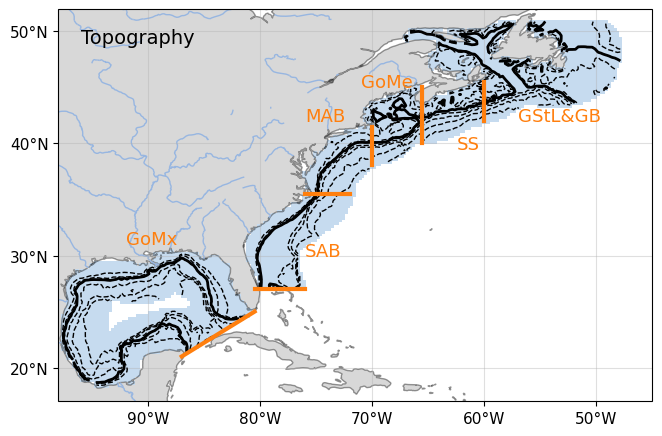

In [282]:
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
shallow_levels = np.arange(0, -201, -25)  # 25m intervals for 0-200m
slope_levels = np.array([-200, -300, -500, -750, -1000, -1500, -2000, -3000, -4000])
levels = np.sort(np.concatenate([shallow_levels, slope_levels]))
# More color gradients in shallow water (0-200m)
colors = [(0.9, 0.9, 1),      # Very light blue for shallow
         (0.7, 0.7, 1),      # Light blue
         (0.5, 0.5, 1),      # Medium light blue
         (0.3, 0.3, 0.9),    # Medium blue
         (0.2, 0.2, 0.8),    # Medium dark blue
         (0.1, 0.1, 0.6),    # Dark blue
         (0, 0, 0.4)]        # Very dark blue
cmap = LinearSegmentedColormap.from_list('custom_bath', colors[::-1])
norm = BoundaryNorm(levels, cmap.N)

fig=plt.figure(figsize=(7,4.5))
ax = plt.subplot(111,projection=projection)
ax.coastlines(alpha=0.4)
ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
ax.add_feature(cfeature.RIVERS)
ax.set_xticks(np.arange(-180,181, 10), crs=projection)
ax.set_yticks(np.arange(20,66, 10), crs=projection)

ax.grid('on',alpha=0.4)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlim([-98,-45])
ax.set_ylim([17,52])

contour_levels = np.sort(np.concatenate([np.array([-4000, -3000, -2000, -1000, -500, -200]),  np.arange(-200, 0, 50)]))
# p0 = ax.pcolor(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0], transform=projection,cmap=cmr.get_sub_cmap('Blues_r', 0.2, 0.9),clim=[-1000,0])
ax.pcolor(lon_product,lat_product,np.ones_like(depth_wide)*mask_wide['mask_Atlantic'][0], transform=projection,cmap=cmr.get_sub_cmap('Blues_r', 0.4, 0.75),clim=[-1000,0])
# cf0 = ax.contourf(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-4000, -3000, -2000, -1000, -200, -150,  -100, -50], cmap=cmap, norm=norm, extend='both')
c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-4000, -3000, -2000, -1000, -200, -100, -50,], colors='k', alpha=1, linewidths=1)
c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200], colors='k', alpha=1, linewidths=2,linestyles='-')
# ax.set_title('Difference between product and SOCAT $p$CO$_2$',fontdict={'size':12})
# plt.clabel(c0, [-200, -1000, -2000], fmt='%1.0f', inline=True, fontsize=8, colors='k')
# ax.text(-70,30,'mean $pCO_2$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
ax.text(-96,49,'Topography',fontdict={'size':14})

ax.plot([-80.5,-87],[25,21],c='tab:orange',linewidth=3) # GoMx & CbS
ax.plot([-80.5,-76],[27,27],c='tab:orange',linewidth=3) # CbS & SAB
ax.plot([-76,-72],[35.5,35.5],c='tab:orange',linewidth=3) # SAB & MAB
ax.plot([-70,-70],[41.5,38.1],c='tab:orange',linewidth=3) # MAB & SS
ax.plot([-65.6,-65.6],[40,45],c='tab:orange',linewidth=3) # SS & GoMa
ax.plot([-60,-60],[42,45.5],c='tab:orange',linewidth=3) # SS & GStL

ax.text(-57,42,'GStL&GB',c='tab:orange',fontdict={'size':13}) 
ax.text(-62.5,39.5,'SS',c='tab:orange',fontdict={'size':13}) 
ax.text(-71,45,'GoMe',c='tab:orange',fontdict={'size':13}) 
ax.text(-76,42,'MAB',c='tab:orange',fontdict={'size':13}) 
ax.text(-76,30,'SAB',c='tab:orange',fontdict={'size':13}) 
ax.text(-92,31,'GoMx',c='tab:orange',fontdict={'size':13}) 

    # ax.text(-100,53,chr(97+i),fontdict={'size':13,'weight':'bold'})
# cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='depth (m)')
# cb0.set_ticks(np.arange(-1000,1,100))
plt.tight_layout()
plt.savefig('figures/Figure_01.jpg',dpi=600)
plt.savefig('figures/Figure_01.pdf')
plt.show()

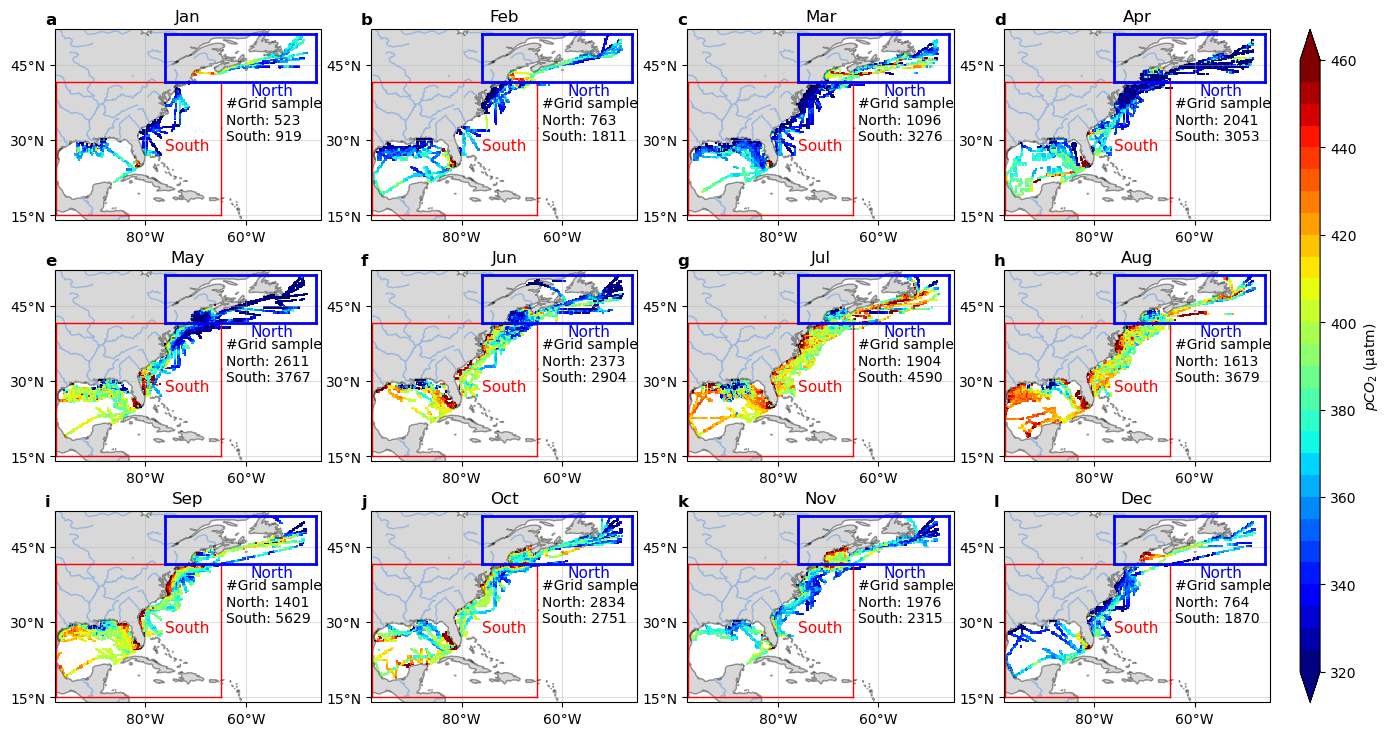

In [283]:
fig = plt.figure(figsize=(14,8))
plt.rcParams.update({"font.size": 10})
# fig.suptitle('Unweighted Monthly Mean $p$CO$_2$ Climatology (1990-2020) from SOCAT Observations',fontdict={'size':13})
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,4),
                axes_pad=0.5,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.3,
                cbar_size='2.5%',
                label_mode='')  # note the empty label_mode
str_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i, ax in enumerate(axgr):
    ax.set_transform(projection)
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([14,52])

    ax.plot([-97.8,-65],[41.5,41.5],c='red',linewidth=1) # MAB & SS
    ax.plot([-97.8,-65],[15,15],c='red',linewidth=1)
    ax.plot([-97.8,-97.8],[15,41.5],c='red',linewidth=1)
    ax.plot([-65,-65],[15,41.5],c='red',linewidth=1)
    ax.text(-76,28,'South',color='red',fontdict={'size':11})

    ax.plot([-76,-46],[41.6,41.6],c='blue',linewidth=2) # MAB & SS
    ax.plot([-76,-46],[51.1,51.1],c='blue',linewidth=2)
    ax.plot([-76,-76],[41.6,51.1],c='blue',linewidth=2)
    ax.plot([-46,-46],[41.6,51.1],c='blue',linewidth=2)
    ax.text(-59,39,'North',color='blue',fontdict={'size':11})

    p0 = ax.pcolor(lon_socat,lat_socat,pco2_socat_clim[i]*mask_wide['mask_Atlantic'][0],cmap=plt.get_cmap('jet',28), clim=[320,460])
    N_north = np.sum(~np.isnan(pco2_socat_4d[:,i] * mask_wide['mask_Atlantic_north'][0]))
    N_south = np.sum(~np.isnan(pco2_socat_4d[:,i] * mask_wide['mask_Atlantic_south'][0]))
    ax.text(-64,30,'#Grid sample\nNorth: %d\nSouth: %d' % (N_north,N_south),fontdict={'size':10})
    ax.text(-100,53,chr(97+i),fontdict={'size':12,'weight':'bold'})
    ax.set_title(str_months[i])

cb = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$\it{p}CO_2$ (µatm)')
plt.tight_layout()
# plt.savefig('figures/Figure_S01.pdf')
plt.show()

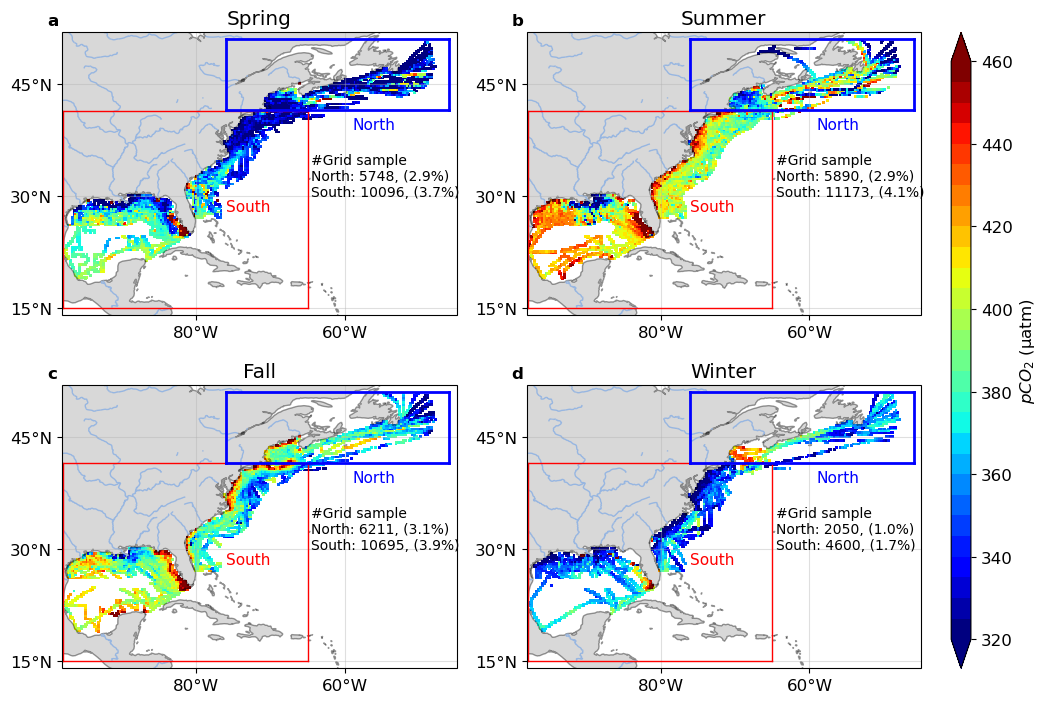

In [284]:
fig = plt.figure(figsize=(12*0.9,8*0.9))
plt.rcParams.update({"font.size": 12})
# fig.suptitle('Unweighted Monthly Mean $p$CO$_2$ Climatology (1990-2020) from SOCAT Observations',fontdict={'size':13})
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2,2),
                axes_pad=0.7,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.3,
                cbar_size='2.5%',
                label_mode='')  # note the empty label_mode
str_seas = ['Spring','Summer','Fall','Winter']
idx_seas = [[2,3,4],[5,6,7],[8,9,10],[11,0,1]]
for i, ax in enumerate(axgr):
    ax.set_transform(projection)
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 20), crs=projection)
    ax.set_yticks(np.arange(15,66, 15), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([14,52])

    ax.plot([-97.8,-65],[41.5,41.5],c='red',linewidth=1) # MAB & SS
    ax.plot([-97.8,-65],[15,15],c='red',linewidth=1)
    ax.plot([-97.8,-97.8],[15,41.5],c='red',linewidth=1)
    ax.plot([-65,-65],[15,41.5],c='red',linewidth=1)
    ax.text(-76,28,'South',color='red',fontdict={'size':11})

    ax.plot([-76,-46],[41.6,41.6],c='blue',linewidth=2) # MAB & SS
    ax.plot([-76,-46],[51.1,51.1],c='blue',linewidth=2)
    ax.plot([-76,-76],[41.6,51.1],c='blue',linewidth=2)
    ax.plot([-46,-46],[41.6,51.1],c='blue',linewidth=2)
    ax.text(-59,39,'North',color='blue',fontdict={'size':11})


    p0 = ax.pcolor(lon_socat,lat_socat,fco2_socat_seas_clim[i]*mask_wide['mask_Atlantic'][0],cmap=plt.get_cmap('jet',28), clim=[320,460])
    r_north = np.sum(~np.isnan(pco2_socat_4d[:,idx_seas[i]] * mask_wide['mask_Atlantic_north'][0]))/np.sum(~np.isnan(pco2_product_4d[:,idx_seas[i]] * mask_wide['mask_Atlantic_north'][0]))
    r_south = np.sum(~np.isnan(pco2_socat_4d[:,idx_seas[i]] * mask_wide['mask_Atlantic_south'][0]))/np.sum(~np.isnan(pco2_product_4d[:,idx_seas[i]] * mask_wide['mask_Atlantic_south'][0]))
    N_north = np.sum(~np.isnan(pco2_socat_4d[:,idx_seas[i]] * mask_wide['mask_Atlantic_north'][0]))
    N_south = np.sum(~np.isnan(pco2_socat_4d[:,idx_seas[i]] * mask_wide['mask_Atlantic_south'][0]))
    ax.text(-64.5,30,'#Grid sample\nNorth: %d, (%.1f%%)\nSouth: %d, (%.1f%%)' % (N_north,r_north*100,N_south,r_south*100),fontdict={'size':10})
    ax.text(-100,53,chr(97+i),fontdict={'size':12,'weight':'bold'})
    ax.set_title(str_seas[i])

cb = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$\it{p}CO_2$ (µatm)')
plt.tight_layout()
plt.savefig('figures/Figure_02.pdf')
plt.savefig('figures/Figure_02.jpg',dpi = 600)
plt.show()

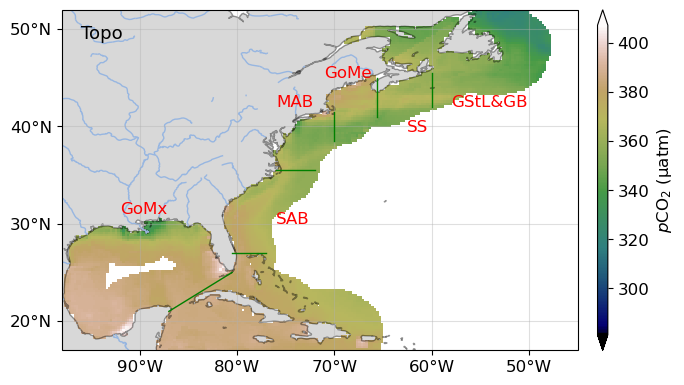

In [285]:
fig=plt.figure(figsize=(7,4.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=(0.7,0.7),
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='2%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 10), crs=projection)
    ax.set_yticks(np.arange(20,66, 10), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([17,52])

    ax.plot([-80.5,-87],[25,21],c='g',linewidth=1) # GoMx & CbS
    ax.plot([-80.5,-77],[27,27],c='g',linewidth=1) # CbS & SAB
    ax.plot([-76,-72],[35.5,35.5],c='g',linewidth=1) # SAB & MAB
    ax.plot([-70,-70],[41.5,38.5],c='g',linewidth=1) # MAB & SS
    ax.plot([-65.6,-65.6],[41,45],c='g',linewidth=1) # SS & GoMa
    ax.plot([-60,-60],[42,45.5],c='g',linewidth=1) # SS & GStL

    ax.text(-58,42,'GStL&GB',c='r') 
    ax.text(-62.5,39.5,'SS',c='r') 
    ax.text(-71,45,'GoMe',c='r') 
    ax.text(-76,42,'MAB',c='r') 
    ax.text(-76,30,'SAB',c='r') 
    ax.text(-92,31,'GoMx',c='r') 
    if i == 0:
        p0 = ax.pcolor(lon_product,lat_product,np.nanmean(fco2_product,axis=0), transform=projection,cmap=plt.get_cmap('gist_earth',200))
        # ax.set_title('Difference between product and SOCAT $p$CO$_2$',fontdict={'size':12})
        a = np.nanmean(np.nanmean(pco2_socat_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        # ax.text(-70,30,'mean $pCO_2$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
        ax.text(-96,49,'Topo',fontdict={'size':13})

    # ax.text(-100,53,chr(97+i),fontdict={'size':13,'weight':'bold'})
cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$p$CO$_2$ (µatm)')
# cb0.set_ticks(np.arange(-1000,1,100))
plt.tight_layout()

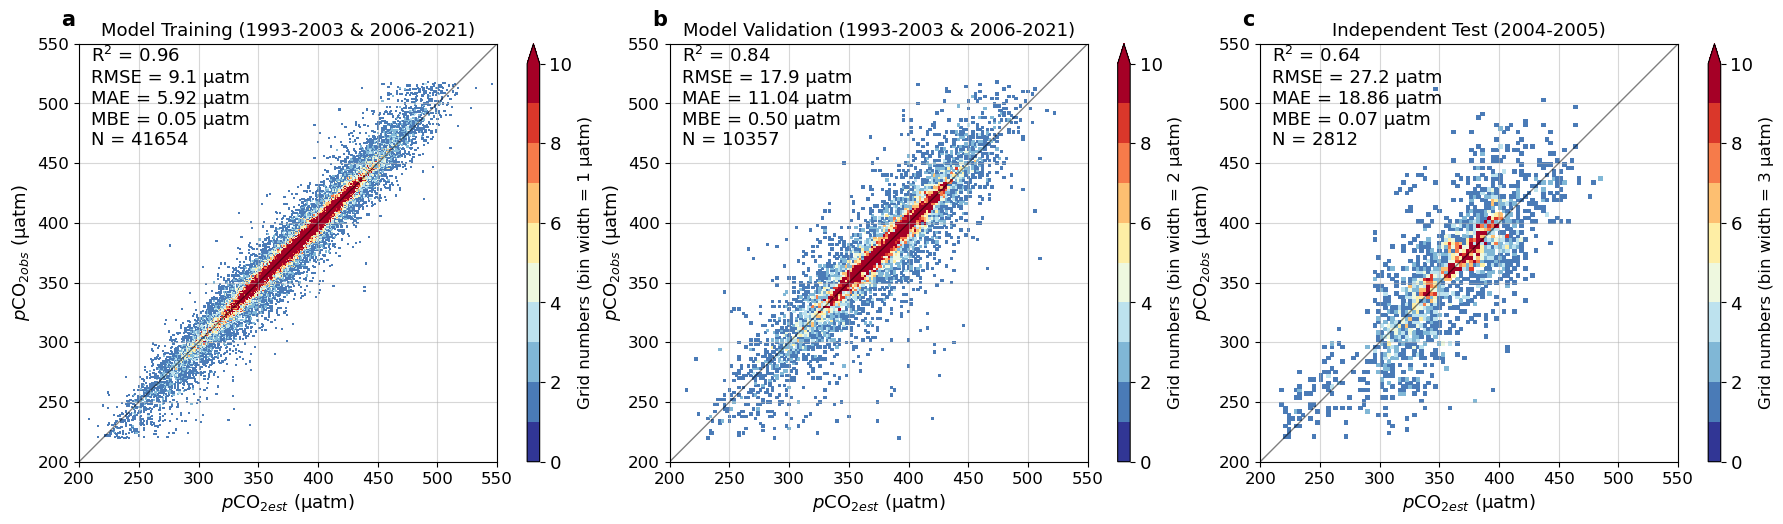

In [286]:
from matplotlib.pylab import f
import statsmodels.tools
import statsmodels.tools.eval_measures

idx_train = ds_product.idx_out_train.values * mask_wide['mask_Atlantic'][0]
idx_test = ds_product.idx_out_test.values * mask_wide['mask_Atlantic'][0]
idx_validation = ds_product.idx_out_validation.values * mask_wide['mask_Atlantic'][0]
idx_20042005 = np.int64(np.arange(2004,2006)-1993)

regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx']
regions_name = ['GStL&GB','SS','GoMe','MAB','SAB','GoMx']

fig = plt.figure(figsize=(18,5.5))
# fig.suptitle('Accuracy of Reconstructed $p$CO$_2$ Product')
axgr = AxesGrid(fig, 111, 
                nrows_ncols=(1,3),
                axes_pad=(1.3,0.75),
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.3,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    key = 'mask_Atlantic'
    if i == 0:
        interval = 1
        # idxvalid = ~np.isnan(pco2_product_4d[idx_train,:]*pco2_socat_4d[idx_train,:]*mask_wide[key][0])
        x = pco2_product*idx_train
        y = pco2_socat*idx_train
        ivalid = ~np.isnan(x*y)
        x = x[ivalid]
        y = y[ivalid]
        ax.set_title('Model Training (1993-2003 & 2006-2021)',fontdict={'size':13})
        dens,x_new,y_new = bin_counts(x,y,[200,700],[200,700],interval)
        nmax = 10
        ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
        p0 = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
        cbar = axgr.cbar_axes[0].colorbar(p0,extend='max',label='Grid numbers (bin width = '+str(interval)+' µatm)')
        cbar.ax.tick_params(labelsize=13)
        cbar.set_label('Grid numbers (bin width = '+str(interval)+' µatm)',fontsize=12)
    elif i == 1:
        interval = 2
        # idxvalid = ~np.isnan(pco2_product_4d[idx_test,:]*pco2_socat_4d[idx_test,:]*mask_wide[key][0])
        x = pco2_product*idx_validation
        y = pco2_socat*idx_validation
        ivalid = ~np.isnan(x*y)
        x = x[ivalid]
        y = y[ivalid]
        ax.set_title('Model Validation (1993-2003 & 2006-2021)',fontdict={'size':13})
        
        dens,x_new,y_new = bin_counts(x,y,[200,700],[200,700],interval)
        nmax = 10
        ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
        p1 = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
        cbar = axgr.cbar_axes[1].colorbar(p1,extend='max',label='Grid numbers (bin width = '+str(interval)+' µatm)')
        cbar.ax.tick_params(labelsize=13)
        cbar.set_label('Grid numbers (bin width = '+str(interval)+' µatm)',fontsize=12)
    elif i == 2:
        interval = 3
        # idxvalid = ~np.isnan(pco2_product_4d[idx_test,:]*pco2_socat_4d[idx_test,:]*mask_wide[key][0])
        # x = pco2_product*idx_validation
        # y = pco2_socat*idx_validation
        x = pco2_product_4d[idx_20042005,:]*mask_wide['mask_Atlantic'][0]
        y = pco2_socat_4d[idx_20042005,:]*mask_wide['mask_Atlantic'][0]
        ivalid = ~np.isnan(x*y)
        x = x[ivalid]
        y = y[ivalid]
        ax.set_title('Independent Test (2004-2005)',fontdict={'size':13})
        
        dens,x_new,y_new = bin_counts(x,y,[200,700],[200,700],interval)
        nmax = 10
        ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
        p2 = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
        cbar = axgr.cbar_axes[2].colorbar(p2,extend='max',label='Grid numbers (bin width = '+str(interval)+' µatm)')
        cbar.ax.tick_params(labelsize=13)
        cbar.set_label('Grid numbers (bin width = '+str(interval)+' µatm)',fontsize=12)
    else:
        print('a')
    # s = ax.scatter(x,y)
    ax.grid('minor',alpha=0.5)
    ax.set_xlim([200,550])
    ax.set_ylim([200,550])
    # plt.scatter(x, y)
    
    lm_i = sm.OLS(y,sm.add_constant(x)).fit()
    rmse_i = statsmodels.tools.eval_measures.rmse(x,y)
    mae_i = statsmodels.tools.eval_measures.meanabs(x,y)
    mbias = np.nanmean(x-y)
    # if i == 0:
    #     ax.text(210,450,'\n(10-fold cross validation)',fontdict={'size':13})
    ax.text(210,465,'R$^2$ = %.2f\nRMSE = %.1f µatm\nMAE = %.2f µatm\nMBE = %.2f µatm\nN = %d' % (lm_i.rsquared, rmse_i,mae_i,mbias, len(x)),fontdict={'size':13})
    ax.text(185,565,chr(97+i),fontdict={'weight':'bold','size':15})
    ax.set_xlabel('${p}$CO$_{2est}$ (µatm)',fontdict={'size':13})
    ax.set_ylabel('${p}$CO$_{2obs}$ (µatm)',fontdict={'size':13})
plt.tight_layout()
plt.savefig('figures/Figure_03.pdf')
plt.savefig('figures/Figure_03.jpg',dpi=600)
plt.show()

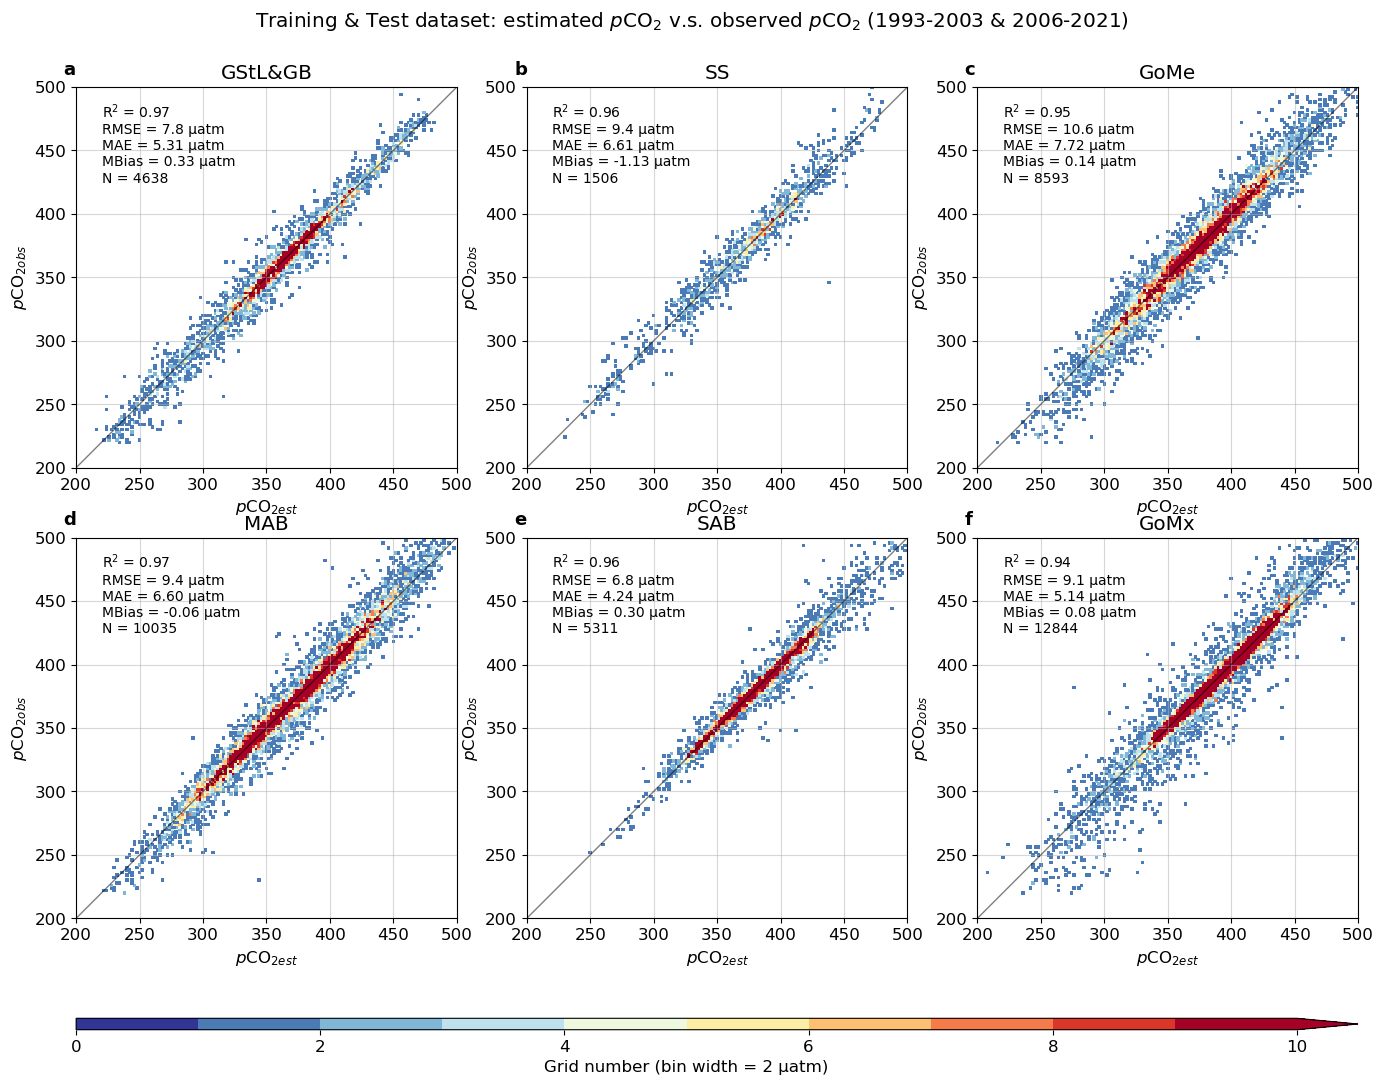

In [287]:
fig = plt.figure(figsize=(14, 8*1.4))
fig.suptitle('Training & Test dataset: estimated ${p}$CO$_{2}$ v.s. observed ${p}$CO$_{2}$ (1993-2003 & 2006-2021)')
axgr = AxesGrid(fig, 111, 
                nrows_ncols=(2,3),
                axes_pad=0.7,
                cbar_location='bottom',
                cbar_mode='single',
                cbar_pad=0.3,
                cbar_size='1%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    key = regions_list[i]
    # idxvalid = ~np.isnan(pco2_product_raw_4d[idx_train,:]*pco2_socat_4d[idx_train,:]*mask_wide[key][0])
    # x = pco2_product_raw_4d[idx_train,:][idxvalid]

    idxvalid = ~np.isnan(pco2_product*pco2_socat*pco2_product*idx_train*mask_wide[key][0])
    x = pco2_product[idxvalid]
    y = pco2_socat[idxvalid]    
    dens,x_new,y_new = bin_counts(x,y,[200,550],[200,550],2)
    nmax = 10
    ax.plot([200,550],[200,550],'k',linewidth=1,alpha=0.5)
    p = ax.pcolor(x_new,y_new,dens.T,clim=[0,nmax],cmap=plt.get_cmap('RdYlBu_r',nmax))
    ax.grid('minor',alpha=0.5)
    ax.set_xlim([200,500])
    ax.set_ylim([200,500])

    lm_i = sm.OLS(y,sm.add_constant(x)).fit()
    rmse_i = statsmodels.tools.eval_measures.rmse(x,y)
    mae_i = statsmodels.tools.eval_measures.meanabs(x,y)
    mbias = np.nanmean(x-y)
    ax.text(220,425,'R$^2$ = %.2f\nRMSE = %.1f µatm\nMAE = %.2f µatm\nMBias = %.2f µatm\nN = %d' % (lm_i.rsquared, rmse_i,mae_i,mbias, len(x)),fontdict={'size':10})

    # plt.scatter(x, y)
    ax.set_title(regions_name[i])
    ax.text(190,510,chr(97+i),fontdict={'weight':'bold','size':13})
    ax.set_xlabel('${p}$CO$_{2est}$')
    ax.set_ylabel('${p}$CO$_{2obs}$')
axgr.cbar_axes[0].colorbar(p,extend='max',label='Grid number (bin width = 2 µatm)')
plt.tight_layout()
# plt.savefig('figures/Figure_Model_Training.pdf')
plt.show()

In [312]:
regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx','mask_Atlantic']
regions_name = ['GStL & GB','SS','GoME','MAB','SAB','GoMX','NAACOM']

idx_train = ds_product.idx_out_train.values * mask_wide['mask_Atlantic'][0]
idx_test = ds_product.idx_out_test.values * mask_wide['mask_Atlantic'][0]
idx_validation = ds_product.idx_out_validation.values * mask_wide['mask_Atlantic'][0]

R2 = np.full(len(regions_list)*4,np.nan)
RMSE = np.full(len(regions_list)*4,np.nan)
MAE = np.full(len(regions_list)*4,np.nan)
MBE = np.full(len(regions_list)*4,np.nan)
NAMES = np.full(len(regions_list)*4,'xxxxxxxxxxx')
Types = np.full(len(regions_list)*4,'xxxxxxxxxxx')
u_validation = {}

for idx in range(len(regions_list)):
    reg = regions_list[idx]
    NAMES[np.int16((idx)*4+0)] = regions_name[idx]
    Types[np.int16((idx)*4+0)] = 'Train'
    idxvalid = ~np.isnan(pco2_product*pco2_socat*pco2_product*idx_train*mask_wide[reg][0])
    x = pco2_product[idxvalid]
    y = pco2_socat[idxvalid]  
    lm_i = sm.OLS(y,sm.add_constant(x)).fit()
    R2[np.int16(idx*4+0)] = lm_i.rsquared
    RMSE[np.int16(idx*4+0)] = statsmodels.tools.eval_measures.rmse(x,y)
    MAE[np.int16(idx*4+0)] = statsmodels.tools.eval_measures.meanabs(x,y)
    MBE[np.int16(idx*4+0)] = np.nanmean(x-y)

    NAMES[np.int16(idx*4+1)] = regions_name[idx]
    Types[np.int16(idx*4+1)] = 'Validation'
    idxvalid = ~np.isnan(pco2_product*pco2_socat*pco2_product*idx_validation*mask_wide[reg][0])
    x = pco2_product[idxvalid]
    y = pco2_socat[idxvalid]  
    lm_i = sm.OLS(y,sm.add_constant(x)).fit()
    R2[np.int16(idx*4+1)] = lm_i.rsquared
    RMSE[np.int16(idx*4+1)] = statsmodels.tools.eval_measures.rmse(x,y)
    MAE[np.int16(idx*4+1)] = statsmodels.tools.eval_measures.meanabs(x,y)
    MBE[np.int16(idx*4+1)] = np.nanmean(x-y)
    u_validation[reg] = statsmodels.tools.eval_measures.rmse(x,y)

    NAMES[np.int16(idx*4+2)] = regions_name[idx]
    Types[np.int16(idx*4+2)] = 'Test'
    x = pco2_product_4d[idx_20042005,:]*mask_wide[reg][0]
    y = pco2_socat_4d[idx_20042005,:]*mask_wide[reg][0]
    idxvalid = ~np.isnan(x*y)
    x = x[idxvalid]
    y = y[idxvalid]
    lm_i = sm.OLS(y,sm.add_constant(x)).fit()
    R2[np.int16(idx*4+2)] = lm_i.rsquared
    RMSE[np.int16(idx*4+2)] = statsmodels.tools.eval_measures.rmse(x,y)
    MAE[np.int16(idx*4+2)] = statsmodels.tools.eval_measures.meanabs(x,y)
    MBE[np.int16(idx*4+2)] = np.nanmean(x-y)

    NAMES[np.int16(idx*4+3)] = regions_name[idx]
    Types[np.int16(idx*4+3)] = 'All'
    idxvalid = ~np.isnan(pco2_product*pco2_socat*pco2_product*mask_wide[reg][0])
    x = pco2_product[idxvalid]
    y = pco2_socat[idxvalid]  
    lm_i = sm.OLS(y,sm.add_constant(x)).fit()
    R2[np.int16(idx*4+3)] = lm_i.rsquared
    RMSE[np.int16(idx*4+3)] = statsmodels.tools.eval_measures.rmse(x,y)
    MAE[np.int16(idx*4+3)] = statsmodels.tools.eval_measures.meanabs(x,y)
    MBE[np.int16(idx*4+3)] = np.nanmean(x-y)

df_model_summary = pd.DataFrame({'Region':NAMES,'Type':Types,'R2':R2,'RMSE':RMSE,'MAE':MAE,'MBE':MBE})
df_model_summary.to_excel('figures/model_summary_chapter3.xlsx',index=False)
df_model_summary

,Region,Type,R2,RMSE,MAE,MBE
0,GStL & GB,Train,0.971111,7.814790,5.310249,0.330891
1,GStL & GB,Validation,0.909892,13.571688,8.829134,0.444070
2,GStL & GB,Test,0.755475,25.232174,16.817267,-5.635992
3,GStL & GB,All,0.939224,11.476179,6.915086,-0.147998
4,SS,Train,0.955277,9.350523,6.606660,-1.125254
5,SS,Validation,0.896809,13.267268,9.413203,-0.898384
6,SS,Test,0.495422,30.920275,24.123233,-3.498468
7,SS,All,0.900387,13.822894,8.891240,-1.318960
8,GoME,Train,0.948588,10.615577,7.722469,0.142852
9,GoME,Validation,0.814165,20.119959,14.346464,0.825945


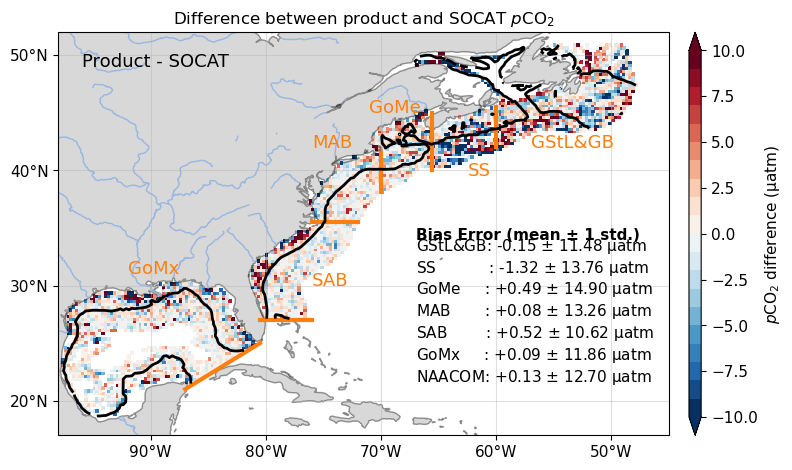

In [349]:
bias = pco2_product - pco2_socat
regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx','mask_Atlantic']
bias_dict = {}
# idxvalid = ~np.isnan(pco2_product*pco2_socat*pco2_product*mask_wide['mask_Atlantic'][0])
# x = pco2_product[idxvalid]
# y = pco2_socat[idxvalid]
# bias = x - y

projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))

fig=plt.figure(figsize=(8,5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=(1.3,0.7),
                cbar_location='right',
                cbar_mode='each',
                cbar_pad=0.2,
                cbar_size='2%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 10), crs=projection)
    ax.set_yticks(np.arange(20,66, 10), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([17,52])

    ax.plot([-80.5,-87],[25,21],c='tab:orange',linewidth=3) # GoMx & CbS
    ax.plot([-80.5,-76],[27,27],c='tab:orange',linewidth=3) # CbS & SAB
    ax.plot([-76,-72],[35.5,35.5],c='tab:orange',linewidth=3) # SAB & MAB
    ax.plot([-70,-70],[41.5,38.1],c='tab:orange',linewidth=3) # MAB & SS
    ax.plot([-65.6,-65.6],[40,45],c='tab:orange',linewidth=3) # SS & GoMa
    ax.plot([-60,-60],[42,45.5],c='tab:orange',linewidth=3) # SS & GStL

    ax.text(-57,42,'GStL&GB',c='tab:orange',fontdict={'size':13}) 
    ax.text(-62.5,39.5,'SS',c='tab:orange',fontdict={'size':13}) 
    ax.text(-71,45,'GoMe',c='tab:orange',fontdict={'size':13}) 
    ax.text(-76,42,'MAB',c='tab:orange',fontdict={'size':13}) 
    ax.text(-76,30,'SAB',c='tab:orange',fontdict={'size':13}) 
    ax.text(-92,31,'GoMx',c='tab:orange',fontdict={'size':13}) 

    if i == 0:
        p0 = ax.pcolor(lon_product,lat_product,np.nanmean(bias,axis=0)*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdBu_r',20,),clim=[-10,10])
        c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=2,linestyles='-')
        ax.set_title('Difference between product and SOCAT $p$CO$_2$',fontdict={'size':12})
        ax.text(-96,49,'Product - SOCAT',fontdict={'size':13})
    for reg in regions_list:
        bias_dict[reg] = bias * mask_wide[reg][0]
    ax.text(-67,34,'Bias Error (mean ± 1 std.)',weight='bold')
    ax.text(-67,20,'GStL&GB: %+.2f $\pm$ %.2f µatm\nSS           : %+.2f $\pm$ %.2f µatm\nGoMe     : %+.2f $\pm$ %.2f µatm\nMAB       : %+.2f $\pm$ %.2f µatm\nSAB        : %+.2f $\pm$ %.2f µatm\nGoMx     : %+.2f $\pm$ %.2f µatm\nNAACOM: %+.2f $\pm$ %.2f µatm\n' % 
            (np.nanmean(bias_dict['mask_GStL']),np.nanstd(bias_dict['mask_GStL']),
             np.nanmean(bias_dict['mask_SS']),np.nanstd(bias_dict['mask_SS']),
             np.nanmean(bias_dict['mask_GoMe']),np.nanstd(bias_dict['mask_GoMe']),
             np.nanmean(bias_dict['mask_MAB']),np.nanstd(bias_dict['mask_MAB']),
             np.nanmean(bias_dict['mask_SAB']),np.nanstd(bias_dict['mask_SAB']),
             np.nanmean(bias_dict['mask_GoMx']),np.nanstd(bias_dict['mask_GoMx']),
             np.nanmean(bias_dict['mask_Atlantic']),np.nanstd(bias_dict['mask_Atlantic']),))
    
cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$p$CO$_2$ difference (µatm)')
# cb0.set_ticks(np.arange(310,411,20))
plt.tight_layout()
plt.savefig('figures/Figure_05.pdf')
plt.savefig('figures/Figure_05.jpg',dpi=600)
plt.show()


In [290]:
area_NAC_grid = loadmat('data/area_NAC.mat')['area_NAC'].T
regions_Pacific = ['mask_AL','mask_NCCS','mask_CCCS','mask_SCCS','mask_Isth']
regions_Atlantic = ['mask_CbS','mask_GoMX','mask_SAB','mask_MAB','mask_GoMe','mask_SS','mask_GStL']

In [291]:
# %% calculate flux
def co_K0_Weiss(sst, sss):
    ###############################################
    # pco2 = CO_XCO2TOPCO2(sst, sss)
    # A function calculated the CO2 solubility with SST (C) and SSS
    # Uncertainty is 2% according to Weiss (1974).
    #
    # Input:
    #   sst: sea surface temperature
    #   sss: sea surface salinity (degree Celcius)
    # Output:
    #   K0: CO2 solubility, unit: mol/l/atm
    #
    # Algorithm:
    # ln_K0 = A1 + A2.*(100./sst) + A3 *log(sst/100) + sss.* (B1+ B2*(sst/100)+ B3*(sst/100).^2);
    # K0 = exp(ln_K0);
    #
    # References:
    # Weiss, R. F. (1974). Carbon dioxide in water and seawater: the solubility of a non-ideal gas. Marine Chemistry, 2(3), 203–215. https://doi.org/10.1016/0304-4203(74)90015-2
    #
    # Zelun Wu
    # Ph.D. student.
    # University of Delaware & Xiamen University
    # zelunwu@outlook.com
    # zelunwu.github.io
    # #############################################

    sss = np.array(sss)
    sst = np.array(sst)
    sst = np.array(sst + 273.15)  # transfer to Kelvin degree
    A1, A2, A3 = -58.0931, 90.5069, 22.294
    B1, B2, B3 = 0.027766, -0.025888, 0.0050578
    ln_K0 = (
        A1
        + A2 * (100 / sst)
        + A3 * np.log(sst / 100)
        + sss * (B1 + B2 * (sst / 100) + B3 * (sst / 100) ** 2)
    )
    K0 = np.exp(ln_K0)
    return K0

def co_gas_transfer_velocity(sst, wspd, c=0.251, unit="cmhr"):
    # kt = co_gas_transfer_velocity(sst,wspd,c,unit)
    # Calculate the gas transfer velocity from sst, sss, and wind speed
    # Input:
    #     sst: sea surface temperature
    #     wspd: wind speed
    #     c: coefficient, default is 0.251 (Wanninkhof, 2014)
    #     unit: 1, or 2. 1 represents unit for k is hour/cm; 2 represents m/yr. default is 1.
    #
    # Output:
    #     kt: gas transfer velocity
    #
    # Uncertainty is 20# on the global average, but should be calibrated with the mooring measured wind speed in the
    # regional ocean.
    #
    # Algorithm:
    # kt = c * wpsd^2 * (Sc/660)^-0.5
    # Sc is the Schmit numer, which is a function of SST:
    # Sc = A + B*(sst) + C*(sst.^2) + D*(sst.^3) + E*(sst.^4);
    # A = 2116.8; B = -136.25; C = 4.7353; D = -0.092307; E = 0.0007555;
    #
    # References:
    # Wanninkhof, R. (2014). Relationship between wind speed and gas exchange over the ocean revisited. Limnology and Oceanography: Methods, 12(6), 351–362. https://doi.org/10.4319/lom.2014.12.351
    #
    # Author:
    # Zelun Wu
    # Ph.D. student.
    # University of Delaware & Xiamen University
    # zelunwu@outlook.com
    # zelunwu.github.io
    ##
    sst = np.array(sst)
    wspd = np.array(wspd)

    A, B, C, D, E = 2116.8, -136.25, 4.7353, -0.092307, 0.0007555
    Sc = (
        A + B * (sst) + C * (sst**2) + D * (sst**3) + E * (sst**4)
    )  # Jähne et al. (1987), Wanninkhof 2014
    kt = c * wspd**2 * ((Sc / 660) ** (-0.5))  # unit: cm/hour
    if not (unit == "cmhr"):
        kt = kt * (24 * 365 / 100)  # unit: m/yr
    return kt


def co_co2flux(pCO2sea, pco2air, sst, sss, wspd):
    pCO2sea = np.array(pCO2sea)
    pco2air = np.array(pco2air)
    sst = np.array(sst)
    sss = np.array(sss)
    wspd = np.array(wspd)

    kt = co_gas_transfer_velocity(sst, wspd, 0.251)
    K0 = co_K0_Weiss(sst, sss)
    dpco2 = pCO2sea - pco2air
    # Because kt is in cm/hour, pCO2 is in µatm, flux in most case is in mol C/m2/yr
    F = kt * K0 * dpco2 * (24 * 365 / 100000)
    return F

def co_xco2topco2(xco2, sst, sss, p=101325):
    # pco2 = CO_XCO2TOPCO2(xco2, sst, sss)
    # A function converted atmospheric mole fraction of CO2 (xCO2) to atmospheric pCO2
    #
    # Algorithm:
    # fco2 = xco2 * (1-pw);
    # pw = exp()...
    #
    # References:
    #
    #
    # Author:
    # Zelun Wu
    # Ph.D. student.
    # University of Delaware & Xiamen University
    # zelunwu@outlook.com
    # zelunwu.github.io
    ##

    xco2 = np.array(xco2)
    sst = np.array(sst)
    sss = np.array(sss)

    C1 = 24.4543
    C2 = -67.4509 * (100 / (sst + 273.15))
    C3 = -4.8489 * np.log((sst + 273.15) / 100)
    C4 = -0.000544 * sss
    pw = np.exp(C1 + C2 + C3 + C4)
    pco2 = xco2 * (p/101325 - pw)
    return pco2

def p2fCO2(pCO2,T=25, P=0, Patm=1):
    # Copyright (C) 2010  Héloïse Lavigne and Jean-Pierre Gattuso
    # with a most valuable contribution of Bernard Gentili <gentili@obs-vlfr.fr>
    # and valuable suggestions from Jean-Marie Epitalon <epitalon@lsce.saclay.cea.fr>
    #
    # This file is part of seacarb.
    #
    # Seacarb is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or any later version.
    #
    # Seacarb is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
    #
    # You should have received a copy of the GNU General Public License along with seacarb; if not, write to the Free Software Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA  02111-1307  USA
    #
    #
    #

    # Original "seacarb" f2pCO2 calculation:
    # B <- (-1636.75+12.0408*TK-0.0327957*(TK*TK)+0.0000316528*(TK*TK*TK))*1e-6
    # fCO2 <-  pCO2*(1/exp((1*100000)*(B+2*(57.7-0.118*TK)*1e-6)/(8.314*TK)))^(-1)
    # Above calculation:
    # - uses incorrect R (wrong units, incompatible with pressure in atm)
    # - neglects a term "x2" (see below)
    # - assumes pressure is always 1 atm (wrong for subsurface)
    tk = 273.15;           # [K] (for conversion [deg C] <-> [K])
    TK = T + tk;           # TK [K]; T[C]
    Phydro_atm = P / 101325  # convert hydrostatic pressure from Pa to atm (1.01325 bar / atm)
    Ptot = Patm + Phydro_atm  # total pressure (in atm) = atmospheric pressure + hydrostatic pressure

    # To compute fugcoeff, we need 3 other terms (B, Del, xc2) in addition to 3 others above (TK, Ptot, R)
    B   = -1636.75 + 12.0408*TK - 0.0327957*TK**2 + 0.0000316528*TK**3
    Del = 57.7-0.118*TK

    # "x2" term often neglected (assumed = 1) in applications of Weiss's (1974) equation 9
    # x2 = 1 - x1 = 1 - xCO2 (it is close to 1, but not quite)
    # Let's assume that xCO2 = pCO2. Resulting fugcoeff is identical to at least 8th digit after the decimal.
    xCO2approx = pCO2
    xc2 = (1 - xCO2approx*1e-6)**2 

    fugcoeff = np.exp( Ptot*(B + 2*xc2*Del)/(82.057*TK) )
    fCO2 = pCO2 * fugcoeff
    return fCO2

In [292]:
# regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx']
# regions_name = ['GStL & GB','SS','GoMe','MAB','SAB','GoMx']

# yrs = np.arange(yr_min,yr_max)

# fig = plt.figure(figsize=(13,6))
# fig.subplots_adjust(hspace=0.3,wspace=0.4)
# plt.rcParams.update({"font.size": 10})
# for idxkey in range(len(regions_list)):
#     reg = regions_list[idxkey]

#     ax = plt.subplot(2,3,idxkey+1)
#     mask_i = mask_wide[reg][0]
#     ts_pco2_i = np.nanmean(pco2_product_4d*pco2_socat_4d/pco2_product_4d * mask_i,axis=(2,3))
#     lns0 = ax.errorbar(np.arange(12)+1,np.nanmean(ts_pco2_i,axis=0),np.nanstd(ts_pco2_i,axis=0),c='k',fmt='o',ls='-',markerfacecolor='white',capsize=3,ms=6,label='SOCAT',linewidth=2)
#     y_i = np.nanmean(ts_pco2_i,axis=0)
#     y_i_std = np.nanstd(ts_pco2_i,axis=0)

#     ts_pco2_i = np.nanmean(pco2_product_4d*pco2_socat_4d/pco2_socat_4d * mask_i,axis=(2,3))
#     lns1 = ax.errorbar(np.arange(12)+1-0.15,np.nanmean(ts_pco2_i,axis=0),np.nanstd(ts_pco2_i,axis=0),c='tab:red',fmt='s',ls='-',markerfacecolor='white',capsize=3,ms=6,label='Product - missing',linewidth=2)
#     y_i = np.nanmean(ts_pco2_i,axis=0)
#     y_i_std = np.nanstd(ts_pco2_i,axis=0)

#     ts_pco2_i = np.nanmean(pco2_product_4d * mask_i,axis=(2,3))
#     lns2 = ax.errorbar(np.arange(12)+1+0.15,np.nanmean(ts_pco2_i,axis=0),np.nanstd(ts_pco2_i,axis=0),c='tab:blue',fmt='^',ls='-',markerfacecolor='white',capsize=3,ms=6,label='Product',linewidth=2)
#     y_i = np.nanmean(ts_pco2_i,axis=0)
#     y_i_std = np.nanstd(ts_pco2_i,axis=0)

#     ax.set_xticks(np.arange(1,13))
#     ax.set_xlim([0.5,12.5])
#     ax.set_ylabel('$p$CO$_2$ (µatm)')
#     ax.text(0,487,chr(97+idxkey),fontdict={'weight':'bold','size':13})

#     ax.set_ylim([250,470])
#     ax.grid(alpha=0.5)
#     ax.set_yticks(np.arange(240,481,40))
    
#     plt.title(regions_name[idxkey])

# fig.legend((lns0,lns1,lns2), ['SOCAT','Product (SOCAT-sampled grid cells, with missing data)','Product without missing data'], loc = 'lower center', labelspacing=0., ncol=4, bbox_to_anchor=(0.5, -0.05))
# fig.show()
# plt.tight_layout()
# plt.savefig('figures/Figure_Seasonality.jpg',dpi=600)

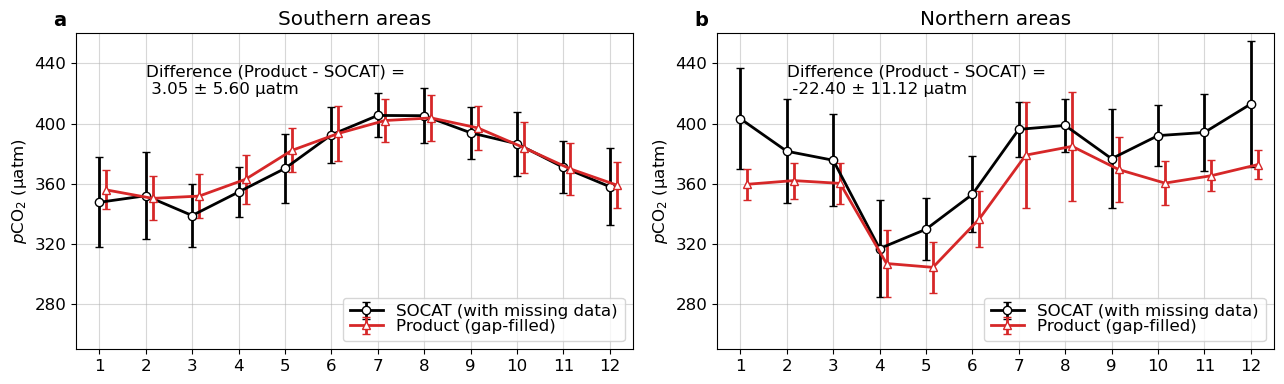

In [293]:
regions_list = ['mask_Atlantic_south','mask_Atlantic_north']
regions_name = ['Southern areas','Northern areas']

yrs = np.arange(yr_min,yr_max)

fig = plt.figure(figsize=(13,4))
fig.subplots_adjust(hspace=0.3,wspace=0.4)
plt.rcParams.update({"font.size": 12})
for idxkey in range(len(regions_list)):
    reg = regions_list[idxkey]

    ax = plt.subplot(1,2,idxkey+1)
    mask_i = mask_wide[reg][0]
    ts_pco2_socat_i = np.nanmean(pco2_product_4d*pco2_socat_4d/pco2_product_4d * mask_i,axis=(2,3))
    lns0 = ax.errorbar(np.arange(12)+1,np.nanmean(ts_pco2_socat_i,axis=0),np.nanstd(ts_pco2_socat_i,axis=0),c='k',fmt='o',ls='-',markerfacecolor='white',capsize=3,ms=6,label='SOCAT',linewidth=2)
    y_i = np.nanmean(ts_pco2_socat_i,axis=0)
    y_i_std = np.nanstd(ts_pco2_socat_i,axis=0)

    # ts_pco2_i = np.nanmean(pco2_product_4d*pco2_socat_4d/pco2_socat_4d * mask_i,axis=(2,3))
    # lns1 = ax.errorbar(np.arange(12)+1-0.15,np.nanmean(ts_pco2_i,axis=0),np.nanstd(ts_pco2_i,axis=0),c='tab:red',fmt='s',ls='-',markerfacecolor='white',capsize=3,ms=6,label='Product - missing',linewidth=2)
    # y_i = np.nanmean(ts_pco2_i,axis=0)
    # y_i_std = np.nanstd(ts_pco2_i,axis=0)

    ts_pco2_product_i = np.nanmean(pco2_product_4d * mask_i,axis=(2,3))
    lns2 = ax.errorbar(np.arange(12)+1+0.15,np.nanmean(ts_pco2_product_i,axis=0),np.nanstd(ts_pco2_product_i,axis=0),c='tab:red',fmt='^',ls='-',markerfacecolor='white',capsize=3,ms=6,label='Product',linewidth=2)
    y_i = np.nanmean(ts_pco2_product_i,axis=0)
    y_i_std = np.nanstd(ts_pco2_product_i,axis=0)

    diff = np.nanmean(ts_pco2_product_i,axis=0) - np.nanmean(ts_pco2_socat_i,axis=0)
    ax.text(2,420,'Difference (Product - SOCAT) = \n %.2f ± %.2f µatm' % (np.nanmean(diff),np.nanstd(diff)),ha='left',fontdict={'size':12})
    ax.set_xticks(np.arange(1,13))
    ax.set_xlim([0.5,12.5])
    ax.set_ylabel('$p$CO$_2$ (µatm)')
    ax.text(0,465,chr(97+idxkey),fontdict={'weight':'bold','size':14})

    
    ax.grid(alpha=0.5)
    ax.set_yticks(np.arange(280,461,40))
    ax.set_ylim([250,460])
    
    plt.title(regions_name[idxkey])
    ax.legend((lns0,lns2), ['SOCAT (with missing data)','Product (gap-filled)'], loc = 'lower right', labelspacing=0., ncol=1, )

fig.show()
plt.tight_layout()
plt.savefig('figures/Figure_06.jpg',dpi=600)
plt.savefig('figures/Figure_06.pdf')

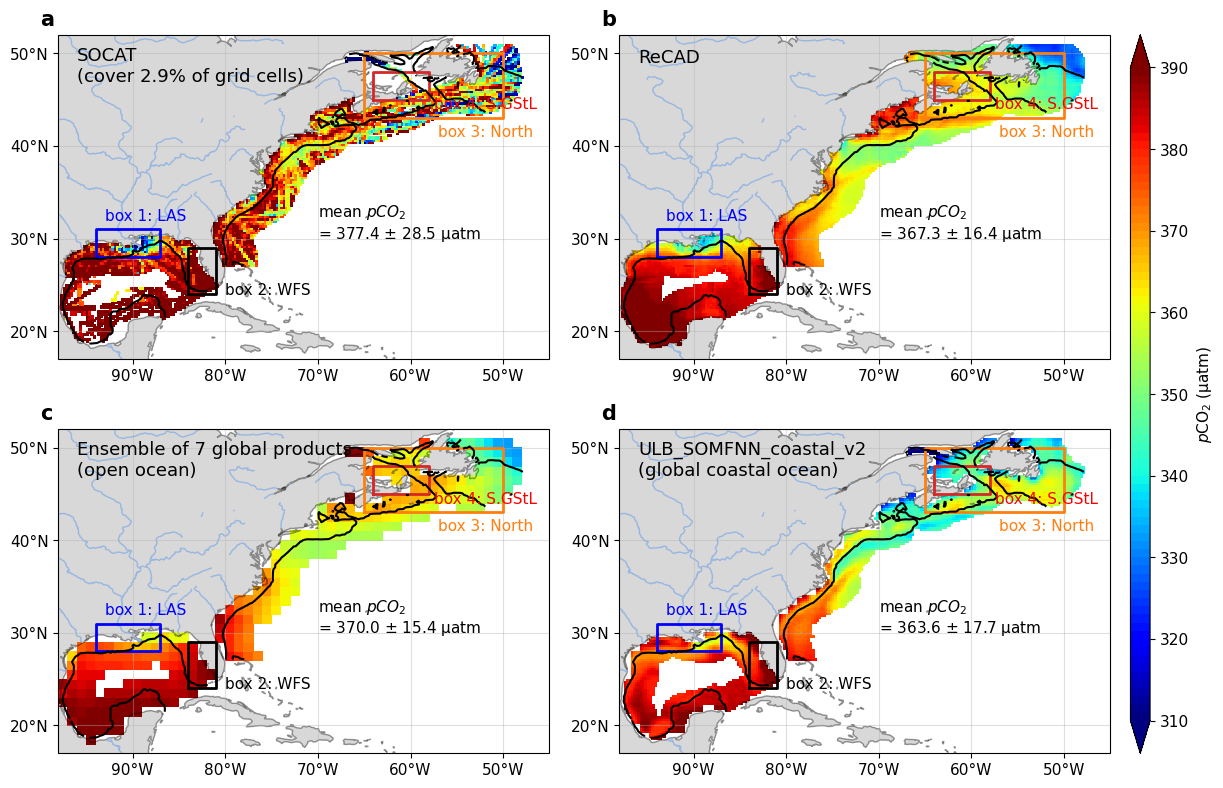

: 

In [359]:

fig=plt.figure(figsize=(13,8))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2,2),
                axes_pad=(0.7,0.7),
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='2%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 10), crs=projection)
    ax.set_yticks(np.arange(20,66, 10), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([17,52])

    ax.plot([-94,-87,-87,-94,-94],[28,28,31,31,28],linewidth=2, c= 'blue') # LAS
    ax.plot([-84,-81,-81,-84,-84],[24,24,29,29,24],linewidth=2, c= 'k') # WFS
    # ax.plot([-76,-71,-71,-76,-76],[36,36,41.5,41.5,36],linewidth=2, c= 'g') # MAB
    ax.plot([-65,-50,-50,-65,-65],[43,43,50,50,43],linewidth=2, c= 'tab:orange') # North
    ax.plot([-64,-58,-58,-64,-64],[45,45,48,48,45],linewidth=2, c= 'tab:red') # North

    ax.text(-93,32,'box 1: LAS', c= 'blue') 
    ax.text(-80,24,'box 2: WFS', c= 'k') 
    # ax.text(-70,37,'Box 3: MAB', c= 'g') 
    ax.text(-57,41,'box 3: North', c= 'tab:orange') 
    ax.text(-57.5,44,'box 4: S.GStL', c= 'red') 
    if i == 0:
        p0 = ax.pcolor(lon_product,lat_product,np.nanmean(np.nanmean(pco2_socat_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('jet',80),clim=[310,390])
        c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=1.5,linestyles='-')
        # ax.set_title('Difference between product and SOCAT $p$CO$_2$',fontdict={'size':12})
        a = np.nanmean(np.nanmean(pco2_socat_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        ax.text(-70,30,'mean $pCO_2$\n= %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
        ax.text(-96,47,'SOCAT\n(cover 2.9% of grid cells)',fontdict={'size':13})
    if i == 1:
        p1 = ax.pcolor(lon_product,lat_product,np.nanmean(np.nanmean(pco2_product_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('jet',80),clim=[310,390])
        c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=1.5,linestyles='-')
        a = np.nanmean(np.nanmean(pco2_product_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        ax.text(-70,30,'mean $pCO_2$\n= %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
        ax.text(-96,49,'ReCAD',fontdict={'size':13})
    if i == 2:
        p2 = ax.pcolor(lon_ensemble,lat_ensemble,np.nanmean(np.nanmean(pco2_ensemble,axis=0),axis=0)*mask_ensemble['mask_Atlantic'], transform=projection,cmap=plt.get_cmap('jet',80),clim=[310,390])
        c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=1.5,linestyles='-')
        a = np.nanmean(np.nanmean(pco2_ensemble,axis=0),axis=0)*mask_ensemble['mask_Atlantic']
        ax.text(-70,30,'mean $pCO_2$\n= %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
        ax.text(-96,47,'Ensemble of 7 global products\n(open ocean)',fontdict={'size':13})
    if i == 3:
        p3 = ax.pcolor(lon_product,lat_product,np.nanmean(pco2_somfnn,axis=0)*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('jet',80,),clim=[310,390])
        c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=1.5,linestyles='-')
        a = np.nanmean(pco2_somfnn,axis=0)*mask_wide['mask_Atlantic'][0]
        ax.text(-70,30,'mean $pCO_2$\n= %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
        ax.text(-96,47,'ULB_SOMFNN_coastal_v2\n(global coastal ocean)',fontdict={'size':13})
    a = np.nanmean(np.nanmean(bias,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
    
    ax.text(-100,53,chr(97+i),fontdict={'size':15,'weight':'bold'})
cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$p$CO$_2$ (µatm)')
# cb0.set_ticks(np.arange(310,411,20))
plt.tight_layout()
plt.savefig('figures/Figure_07.jpg',dpi=600)
plt.savefig('figures/Figure_07.pdf')
plt.show()

In [295]:
pco2_product_clim = np.nanmean(pco2_product_4d,axis=0)
pco2_product_anom_4d = pco2_product_4d - pco2_product_clim
pco2_product_anom_3d = pco2_product_anom_4d.reshape(pco2_product.shape)
pco2_product_anom_3d_1 = pco2_product_anom_3d[:168]
pco2_product_anom_3d_2 = pco2_product_anom_3d[168:]

tr_all = np.full(pco2_product_clim[0].shape,np.nan)
tr_1 = np.full(pco2_product_clim[0].shape,np.nan)
tr_2 = np.full(pco2_product_clim[0].shape,np.nan)

for idxlat in range(len(lat_product)):
    for idxlon in range(len(lon_product)):
        y_i = pco2_product_anom_3d[:,idxlat,idxlon]
        t_i = np.arange(0,len(y_i))/12
        ivalid = ~np.isnan(y_i)
        if sum(ivalid)>100:
            lm_i = sm.OLS(y_i[ivalid],sm.add_constant(t_i[ivalid])).fit()
            tr_all[idxlat,idxlon] = lm_i.params[1]
        
        y_i_1 = pco2_product_anom_3d_1[:,idxlat,idxlon]
        t_i_1 = np.arange(0,len(y_i_1))/12
        ivalid_1 = ~np.isnan(y_i_1)
        if sum(ivalid_1)>100:
            lm_i_1 = sm.OLS(y_i_1[ivalid_1],sm.add_constant(t_i_1[ivalid_1])).fit()
            tr_1[idxlat,idxlon] = lm_i_1.params[1]
        
        y_i_2 = pco2_product_anom_3d_2[:,idxlat,idxlon]
        t_i_2 = np.arange(0,len(y_i_2))/12
        ivalid_2 = ~np.isnan(y_i_2)
        if sum(ivalid_2)>100:
            lm_i_2 = sm.OLS(y_i_2[ivalid_2],sm.add_constant(t_i_2[ivalid_2])).fit()
            tr_2[idxlat,idxlon] = lm_i_2.params[1]

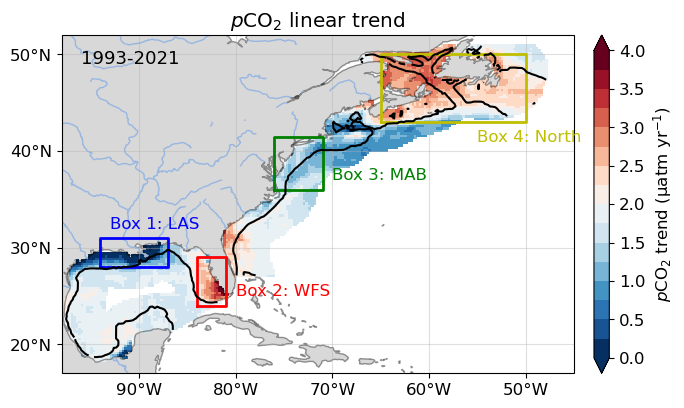

In [296]:

fig=plt.figure(figsize=(7,4.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=(0.7,0.5),
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 10), crs=projection)
    ax.set_yticks(np.arange(20,66, 10), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([17,52])

    # ax.plot([-80.5,-87],[25,21],c='k',linewidth=1.5) # GoMx & CbS
    # ax.plot([-80.5,-77],[27,27],c='k',linewidth=1.5) # CbS & SAB
    # ax.plot([-76,-72],[35.5,35.5],c='k',linewidth=1.5) # SAB & MAB
    # ax.plot([-70,-70],[41.5,38.5],c='k',linewidth=1.5) # MAB & SS
    # ax.plot([-65.6,-65.6],[41,45],c='k',linewidth=1.5) # SS & GoMa
    # ax.plot([-60,-60],[42,45.5],c='k',linewidth=1.5) # SS & GStL

    # ax.text(-58,42,'GStL&GB') 
    # ax.text(-62.5,39.5,'SS') 
    # ax.text(-71,45,'GoMe') 
    # ax.text(-76,42,'MAB') 
    # ax.text(-76,30,'SAB') 
    # ax.text(-92,25,'GoMx') 
    ax.plot([-94,-87,-87,-94,-94],[28,28,31,31,28],linewidth=2, c= 'blue') # LAS
    ax.plot([-84,-81,-81,-84,-84],[24,24,29,29,24],linewidth=2, c= 'r') # WFS
    ax.plot([-76,-71,-71,-76,-76],[36,36,41.5,41.5,36],linewidth=2, c= 'g') # MAB
    ax.plot([-65,-50,-50,-65,-65],[43,43,50,50,43],linewidth=2, c= 'y') # MAB

    ax.text(-93,32,'Box 1: LAS', c= 'blue') 
    ax.text(-80,25,'Box 2: WFS', c= 'r') 
    ax.text(-70,37,'Box 3: MAB', c= 'g') 
    ax.text(-55,41,'Box 4: North', c= 'y') 
    if i == 0:
        p0 = ax.pcolor(lon_product,lat_product,tr_all*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdBu_r',16),clim=[0,4])
        c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=1.5,linestyles='-')
        # ax.set_title('Difference between product and SOCAT $p$CO$_2$',fontdict={'size':12})
        # a = np.nanmean(np.nanmean(pco2_socat_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        # ax.text(-70,30,'mean $pCO_2$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
        ax.text(-96,49,'1993-2021',fontdict={'size':13})
    # if i == 1:
    #     p1 = ax.pcolor(lon_product,lat_product,tr_1*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdBu_r',16),clim=[0,4])
    #     c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=1.5,linestyles='-')
    #     # a = np.nanmean(np.nanmean(pco2_product_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
    #     # ax.text(-70,30,'mean $pCO_2$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
    #     ax.text(-96,49,'Earlier Period: 1993-2006',fontdict={'size':13})
    # if i == 2:
    #     p2 = ax.pcolor(lon_product,lat_product,tr_2*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdBu_r',16),clim=[0,4])
    #     c0 = ax.contour(lon_product,lat_product,depth_wide*mask_wide['mask_Atlantic'][0],levels=[-200],colors='k',linewidths=1.5,linestyles='-')
    #     # a = np.nanmean(np.nanmean(pco2_ensemble,axis=0),axis=0)*mask_ensemble['mask_Atlantic']
    #     # ax.text(-70,30,'mean $pCO_2$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
    #     ax.text(-96,49,'Later Period: 2007-2021',fontdict={'size':13})

    # a = np.nanmean(np.nanmean(bias,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
    
    # ax.text(-100,53,chr(97+i),fontdict={'size':13,'weight':'bold'})
    ax.set_title('$p$CO$_2$ linear trend')
cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$p$CO$_2$ trend (µatm yr$^{-1}$)')
# cb0.set_ticks(np.arange(310,411,20))
plt.tight_layout()
# plt.savefig('figures/Figure_08.jpg',dpi=600)
plt.show()

In [297]:
mask_ts = {}
mask_ts['LAS'] = np.float64((lon_msh>=-94)  & (lon_msh<=-87) & (lat_msh>=28) & (lat_msh<=31))
mask_ts['LAS'][mask_ts['LAS']<0.5] = np.nan
mask_ts['WFS'] = np.float64((lon_msh>=-84)  & (lon_msh<=-81) & (lat_msh>=24) & (lat_msh<=29))
mask_ts['WFS'][mask_ts['WFS']<0.5] = np.nan
mask_ts['MAB'] = np.float64((lon_msh>=-76)  & (lon_msh<=-71) & (lat_msh>=36) & (lat_msh<=41.5))
mask_ts['MAB'][mask_ts['MAB']<0.5] = np.nan
mask_ts['North'] = np.float64((lon_msh>=-65)  & (lon_msh<=-50) & (lat_msh>=43) & (lat_msh<=50))
mask_ts['North'][mask_ts['North']<0.5] = np.nan

ts_pco2_socat = {}
ts_pco2_socat['LAS'] = np.nanmean(pco2_socat * mask_ts['LAS'], axis=(1,2))
ts_pco2_socat['WFS'] = np.nanmean(pco2_socat * mask_ts['WFS'], axis=(1,2))
ts_pco2_socat['MAB'] = np.nanmean(pco2_socat * mask_ts['MAB'], axis=(1,2))
ts_pco2_socat['North'] = np.nanmean(pco2_socat * mask_ts['North'], axis=(1,2))

ts_pco2_product = {}
ts_pco2_product['LAS'] = np.nanmean(pco2_product * mask_ts['LAS'], axis=(1,2))
ts_pco2_product['WFS'] = np.nanmean(pco2_product * mask_ts['WFS'], axis=(1,2))
ts_pco2_product['MAB'] = np.nanmean(pco2_product * mask_ts['MAB'], axis=(1,2))
ts_pco2_product['North'] = np.nanmean(pco2_product * mask_ts['North'], axis=(1,2))


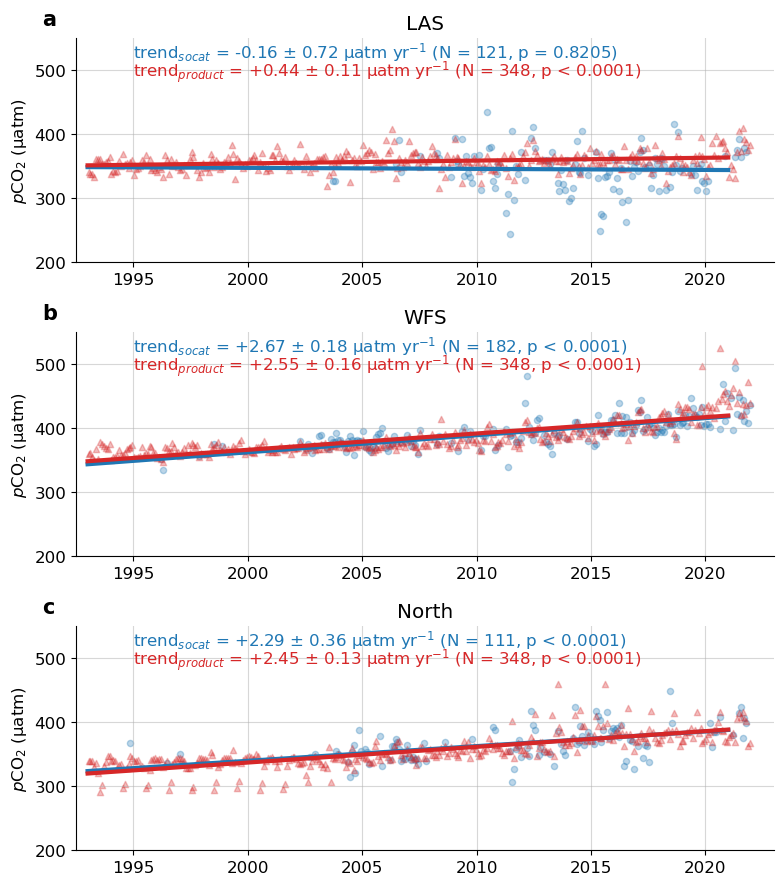

In [298]:
time_decimal = np.arange(1993+1/24,2022,1/12)
colors = ['tab:blue','tab:orange']
trend_dict = {}
regs = ['LAS','WFS','North']

fig = plt.figure(figsize=(8, 9))
fig.subplots_adjust(hspace=0.3,wspace=0.2)
for idxreg in range(3):
    reg = regs[idxreg]
    ax = plt.subplot(3,1,idxreg+1)
    x1 = time_decimal
    y1 = ts_pco2_socat[reg]
    idxvalid = ~np.isnan(x1*y1)
    trend_dict[reg] = calc_trend_Sutton(x1, y1, 5)
    y1_deseason = trend_dict[reg]['ts_monthly_deseason']

    lm_i = trend_dict[reg]['model']
    slope = lm_i.params[1]
    slope_err = lm_i.bse[1]
    r_squared = lm_i.rsquared
    p_value = lm_i.pvalues[1]

    ax.scatter(x1 ,y1_deseason,s=20,marker="o",color='tab:blue',alpha=0.3,label="$\it{p}$CO$_{2}$ " + reg,facecolors='tab:blue')
    ax.plot(np.arange(1993,2022) ,lm_i.predict(sm.add_constant(np.arange(1993,2022))),linewidth=3,color='tab:blue',label="$\it{p}$CO$_{2}$ "+reg+" - fitted")

    if p_value< 0.0001:
        str_tr_socat = 'trend$_{socat}$ = %+.2f ± %.2f µatm yr$^{-1}$ (N = %d, p < 0.0001)' % (slope, slope_err, np.sum(idxvalid))
    else:
        str_tr_socat = 'trend$_{socat}$ = %+.2f ± %.2f µatm yr$^{-1}$ (N = %d, p = %.4f)' % (slope, slope_err, np.sum(idxvalid), p_value)
    
    ax.text(1995,520,str_tr_socat,color='tab:blue')

    y1 = ts_pco2_product[reg]
    idxvalid = ~np.isnan(x1*y1)
    trend_dict[reg] = calc_trend_Sutton(x1, y1, 5)
    y1_deseason = trend_dict[reg]['ts_monthly_deseason']

    lm_i = trend_dict[reg]['model']
    slope = lm_i.params[1]
    slope_err = lm_i.bse[1]
    r_squared = lm_i.rsquared
    p_value = lm_i.pvalues[1]

    ax.scatter(x1 ,y1_deseason,s=20,marker="^",color='tab:red',alpha=0.3,label="$\it{p}$CO$_{2}$ " + reg,facecolors='tab:red')
    ax.plot(np.arange(1993,2022) ,lm_i.predict(sm.add_constant(np.arange(1993,2022))),linewidth=3,color='tab:red',label="$\it{p}$CO$_{2}$ "+reg+" - fitted")

    if p_value < 0.0001:
        str_tr_product = 'trend$_{product}$ = %+.2f ± %.2f µatm yr$^{-1}$ (N = %d, p < 0.0001)' % (slope, slope_err, np.sum(idxvalid))
    else:
        str_tr_product = 'trend$_{product}$ = %+.2f ± %.2f µatm yr$^{-1}$ (N = %d, p = %.4f)' % (slope, slope_err, np.sum(idxvalid), p_value)
    ax.text(1995,490,str_tr_product,color='tab:red')

    ax.set_ylim([200, 550])
    ax.set_xlim([1992.5, 2023])

    ylim = ax.get_ylim()

    ax.set_xticks(range(1995, 2022,5))
    ax.set_ylabel("$\it{p}$CO$_2$ (µatm)")

    ylim = np.array(ax.get_ylim())
    ax.grid('on',alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(reg)
    ax.text(1991,570,chr(97+idxreg),fontdict={'weight':'bold','size':15})
plt.tight_layout()
plt.savefig('figures/Figure_08.jpg',dpi=600)
plt.savefig('figures/Figure_08.pdf')
plt.show()

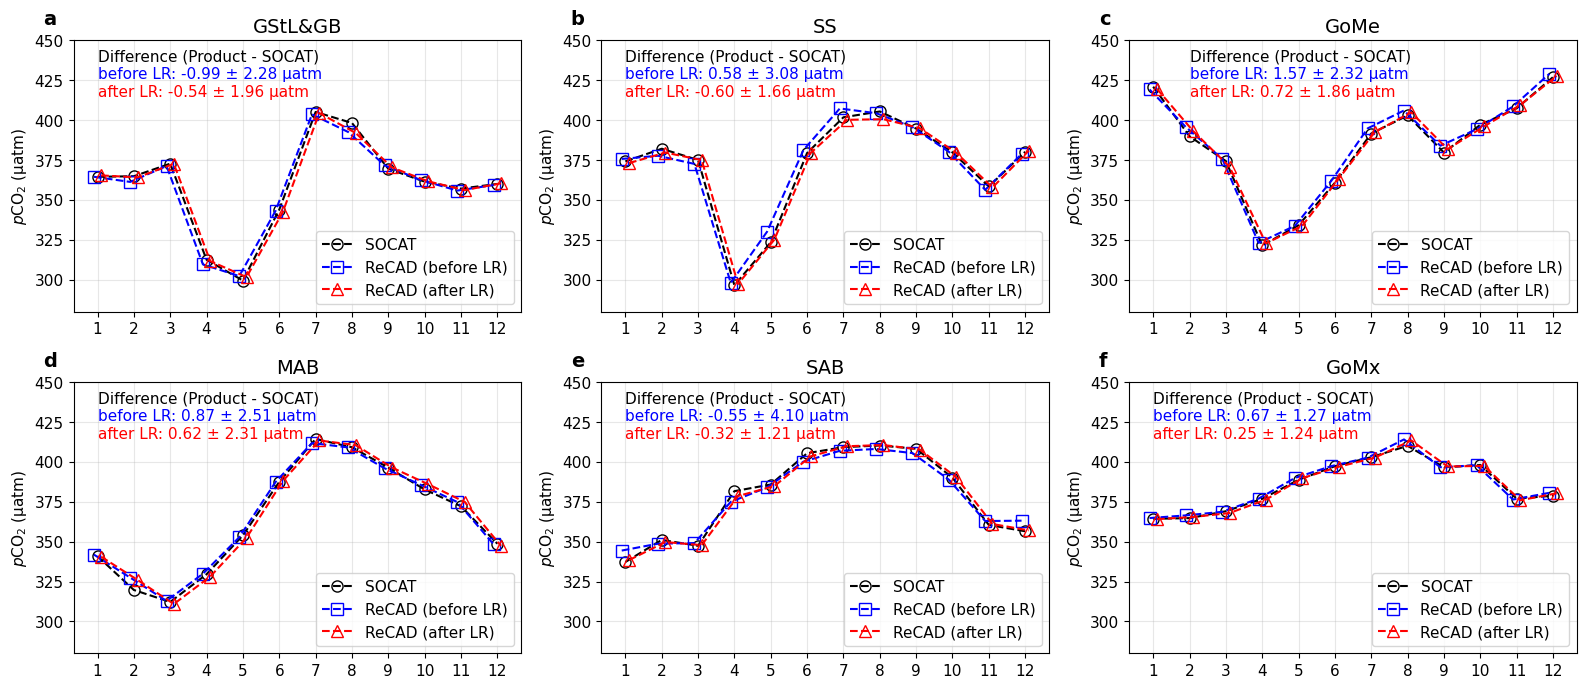

In [322]:
fco2_product_noLR = ds_product.fco2_product_noLR.values
pco2_product_noLR = fco2_product_noLR *(1.00436 - 4.669 * 10**-5 * sst_oisst_3d)

regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx']
regions_name = ['GStL&GB','SS','GoMe','MAB','SAB','GoMx']

y_socat_i = {}
y_product_i = {}
y_product_noLR_i = {}
tr_socat_i = {}
tr_product_i = {}
tr_product_noLR_i = {}

t = np.arange(1993,2022,1/12)
for reg in regions_list:
    y_socat_i[reg] = np.nanmean(pco2_socat * mask_wide[reg],axis=(1,2))
    tr_socat_i[reg] = calc_trend_Sutton(t, y_socat_i[reg], 5)

    y_product_noLR_i[reg] = np.nanmean(pco2_socat * pco2_product_noLR / pco2_socat * mask_wide[reg],axis=(1,2))
    tr_product_noLR_i[reg] = calc_trend_Sutton(t, y_product_noLR_i[reg], 5)

    y_product_i[reg] = np.nanmean(pco2_socat * pco2_product / pco2_socat * mask_wide[reg],axis=(1,2))
    tr_product_i[reg] = calc_trend_Sutton(t, y_product_i[reg], 5)


fig=plt.figure(figsize=(16,7))
# fig.subplots_adjust(hspace=0.)
plt.rcParams['font.size']=11
for ikey in range(6):
    reg = regions_list[ikey]
    ax = plt.subplot(2,3,ikey+1)

    y1 = tr_socat_i[reg]['monthly_clim']
    y2 = tr_product_noLR_i[reg]['monthly_clim']
    y3 = tr_product_i[reg]['monthly_clim']

    y1 = np.nanmean(np.reshape(y_socat_i[reg],[-1,12]),axis=0)
    y2 = np.nanmean(np.reshape(y_product_noLR_i[reg],[-1,12]),axis=0)
    y3 = np.nanmean(np.reshape(y_product_i[reg],[-1,12]),axis=0)

    diff1 = y2 - y1
    diff2 = y3 - y1

    ax.plot(np.arange(1,13),y1,'--k',mec='k',mfc='None',marker='o',ms=8,label='SOCAT')
    ax.plot(np.arange(1,13)-0.1,y2,'--b',mec='blue',mfc='None',marker='s',ms=8,label='ReCAD (before LR)')
    ax.plot(np.arange(1,13)+0.1,y3,'--r',mec='red',mfc='None',marker='^',ms=8,label='ReCAD (after LR)')

    ax.set_ylim([280,450])
    ax.set_xticks(np.arange(1,13))
    x_text = 1
    if ikey == 2:
        x_text = 2
    ax.text(x_text,415,'Difference (Product - SOCAT)\n\n',ha='left')
    ax.text(x_text,415,'before LR: %.2f ± %.2f µatm\n' % (diff1.mean(),diff1.std()),ha='left',color='blue')
    ax.text(x_text,415,'after LR: %.2f ± %.2f µatm' % (diff2.mean(),diff2.std()),ha='left',color='red')

    ax.legend(loc='lower right')
    ax.text(-0.5,460,chr(97+ikey),fontdict={'weight':'bold','size':14})
    ax.set_ylabel('$p$CO$_2$ (µatm)')
    ax.grid(alpha=0.3)
    ax.set_title(regions_name[ikey],fontdict={'size':14})

plt.tight_layout()
plt.savefig('figures/Figure_A1.jpg',dpi=600)
plt.savefig('figures/Figure_A1.pdf',)
plt.show()


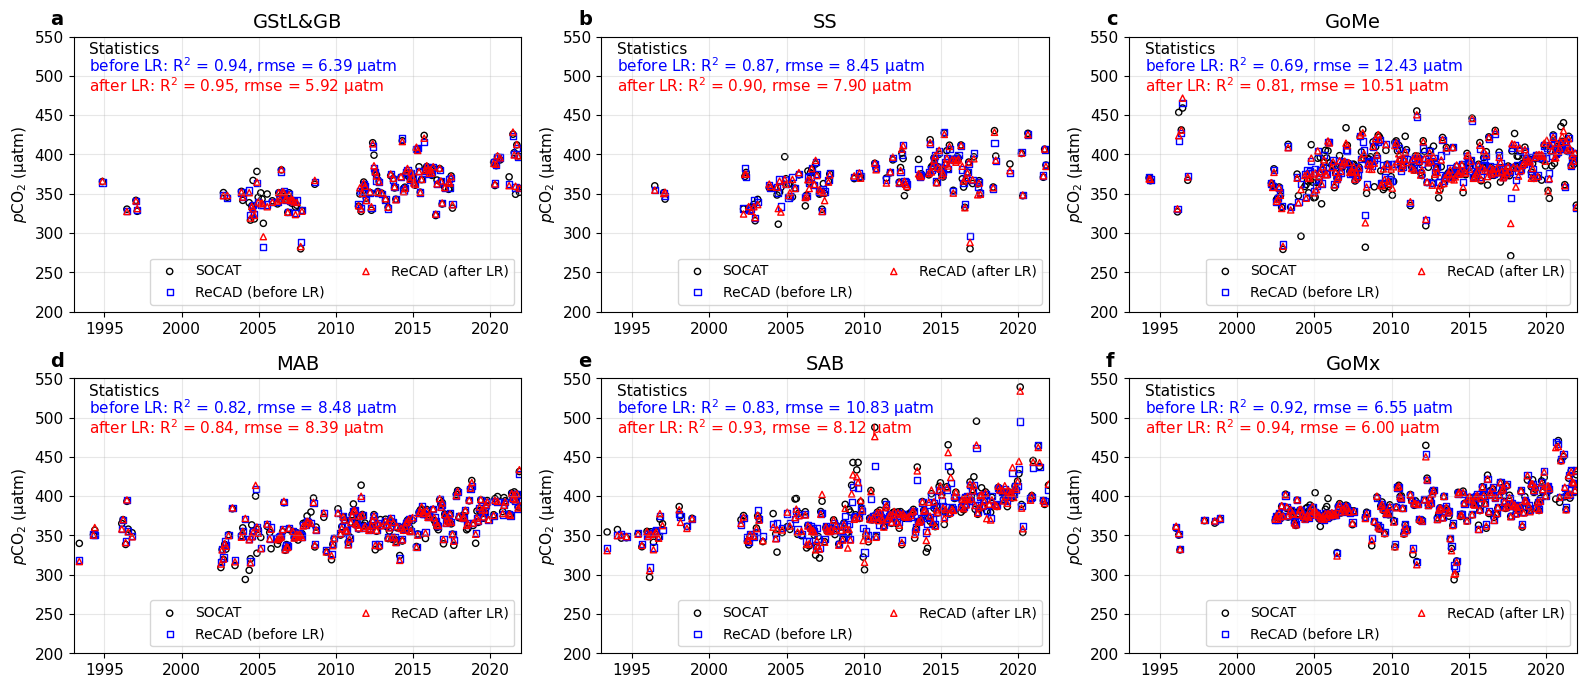

In [323]:

fig=plt.figure(figsize=(16,7))
# fig.subplots_adjust(hspace=0.)
plt.rcParams['font.size']=11
for ikey in range(6):
    reg = regions_list[ikey]
    ax = plt.subplot(2,3,ikey+1)

    y1 = tr_socat_i[reg]['ts_monthly_deseason']
    y2 = tr_product_noLR_i[reg]['ts_monthly_deseason']
    y3 = tr_product_i[reg]['ts_monthly_deseason']

    r21, rmse1 = calculate_metrics(y2,y1)
    r22, rmse2 = calculate_metrics(y3,y1)

    ax.scatter(time_decimal,y1,edgecolors='k',c='None',marker='o',s=20,label='SOCAT')
    ax.scatter(time_decimal,y2,edgecolors='blue',c='None',marker='s',s=20,label='ReCAD (before LR)')
    ax.scatter(time_decimal,y3,edgecolors='red',c='None',marker='^',s=20,label='ReCAD (after LR)')

    ax.set_ylim([200,550])
    ax.set_xlim([1993,2022])
    # ax.set_xticks(np.arange(1,13))
    x_text = 1994
    y_text = 480
    # if ikey == 2:
    #     x_text = 2
    ax.text(x_text,y_text+4,'Statistics\n\n',ha='left')
    ax.text(x_text,y_text,'before LR: R$^2$ = %.2f, rmse = %.2f µatm\n' % (r21,rmse1),ha='left',color='blue')
    ax.text(x_text,y_text,'after LR: R$^2$ = %.2f, rmse = %.2f µatm' % (r22,rmse2),ha='left',color='red')

    ax.legend(loc='lower right',ncol=2,fontsize=10)
    ax.text(1991.5,565,chr(97+ikey),fontdict={'weight':'bold','size':14})
    ax.set_ylabel('$p$CO$_2$ (µatm)')
    ax.grid(alpha=0.3)
    ax.set_title(regions_name[ikey],fontdict={'size':14})

plt.tight_layout()
plt.savefig('figures/Figure_A2.jpg',dpi=600)
plt.savefig('figures/Figure_A2.pdf',)
plt.show()

In [301]:
idx_traintest = np.int32(np.concatenate((np.arange(1993,2004),np.arange(2006,2022))) - 1993)
idx_validationyrs = np.int32(np.arange(2004,2006) - 1993)

x = pco2_socat_4d[idx_traintest,:,:,:]*mask_wide['mask_Atlantic'][0]
y = pco2_product_4d[idx_traintest,:,:,:]*mask_wide['mask_Atlantic'][0]
ivalid = ~np.isnan(x*y)
x = x[ivalid]
y = y[ivalid]
lm_i = sm.OLS(y,sm.add_constant(x)).fit()
r_i = lm_i.rsquared
rmse_i = np.sqrt(np.mean((y - lm_i.predict(sm.add_constant(x)))**2))
mae_i = np.mean(np.abs(y - lm_i.predict(sm.add_constant(x))))
mbe_i = np.mean(y - lm_i.predict(sm.add_constant(x)))
print(r_i,rmse_i,mae_i,mbe_i)

# x = pco2_socat_4d[idx_validationyrs,:,:,:]*mask_wide['mask_Atlantic'][0]
# y = pco2_product_4d[idx_validationyrs,:,:,:]*mask_wide['mask_Atlantic'][0]
# ivalid = ~np.isnan(x*y)
# x = x[ivalid]
# y = y[ivalid]
# lm_i = sm.OLS(y,sm.add_constant(x)).fit()
# r_i = lm_i.rsquared
# rmse_i = np.sqrt(np.mean((y - lm_i.predict(sm.add_constant(x)))**2))
# mae_i = np.mean(np.abs(y - lm_i.predict(sm.add_constant(x))))
# mbe_i = np.mean(y - lm_i.predict(sm.add_constant(x)))
# print(r_i,rmse_i,mae_i,mbe_i)

0.934341145836987 10.958770882457618 6.936295869146163 4.632545738280059e-13


In [302]:
file_unc = 'data/uncertainty.mat'
ds_unc = loadmat(file_unc)
u_sss = np.transpose(ds_unc['diff_sss_withnan'],(3,2,1,0))
u_sst = np.transpose(ds_unc['diff_sst_withnan'],(3,2,1,0))
u_ssh = np.transpose(ds_unc['diff_ssh_withnan'],(3,2,1,0))
u_pco2air = np.transpose(ds_unc['diff_pco2air_withnan'],(3,2,1,0))
u_inputs = np.transpose(ds_unc['diff_all_withnan'],(3,2,1,0))

In [303]:
u_meas = np.full_like(u_inputs, 5.0)
u_meas = u_meas * mask_wide['mask_Atlantic'][0]

regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx','mask_Atlantic']
regions_name = ['GStL&GB','SS','GoMe','MAB','SAB','GoMx','NAACOM']

rmse_regions = {}

for mask_i in regions_list:
    idxvalid = ~np.isnan(pco2_product*pco2_socat*pco2_product*mask_wide[mask_i][0])
    y_est = pco2_product[idxvalid]
    y_obs = pco2_socat[idxvalid]  
    ivalid = ~np.isnan(y_obs.flatten() * y_est.flatten())
    rmse_regions[mask_i] = statsmodels.tools.eval_measures.rmse(y_est,y_obs)

u_grid = np.full_like(u_meas, -5.0).flatten()
u_map = np.full_like(u_meas, -5.0).flatten()


for mask_i in regions_list[:-1]:
    u_i = np.full(u_meas.shape, 1.0)
    u_i = u_i * mask_wide[mask_i][0] * rmse_regions[mask_i]
    ivalid = ~np.isnan(u_i.flatten())
    u_map[ivalid] = u_i.flatten()[ivalid].copy()

    u_i = np.full(u_meas.shape, 1.0)
    u_i = u_i * mask_wide[mask_i][0] * np.nanmean(fco2_socat_std * mask_wide[mask_i][0])
    ivalid = ~np.isnan(u_i.flatten())
    u_grid[ivalid] = u_i.flatten()[ivalid].copy()

u_grid[u_grid<0] = np.nan
u_grid = u_grid.reshape(u_meas.shape)
u_map[u_map<0] = np.nan
u_map = u_map.reshape(u_meas.shape)

u_all = np.sqrt(u_meas**2 + u_map**2 + u_grid**2 + u_inputs**2)

In [304]:
rmse_regions

{'mask_GStL': 11.476178660147248,
 'mask_SS': 13.82289408841986,
 'mask_GoMe': 14.911131879652922,
 'mask_MAB': 13.257910193453423,
 'mask_SAB': 10.634765458853924,
 'mask_GoMx': 11.856268561610541,
 'mask_Atlantic': 12.702094289437781}

In [315]:
regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx','mask_Atlantic']
regions_name = ['GStL&GB','SS','GoMe','MAB','SAB','GoMx','NAACOM']

u_grid_list = np.full(len(regions_list),np.nan)
u_meas_list = np.full(len(regions_list),np.nan)
u_map_list = np.full(len(regions_list),np.nan)
u_inputs_list = np.full(len(regions_list),np.nan)
u_all_list = np.full(len(regions_list),np.nan)

for i in range(len(regions_list)):
    mask_i = regions_list[i]
    u_meas_list[i] = 5.0
    u_grid_list[i] = np.nanmean(u_grid * mask_wide[mask_i][0])
    # u_map_list[i] = rmse_regions[mask_i]
    u_map_list[i] = u_validation[mask_i]
    u_inputs_list[i] = np.nanmean(u_inputs * mask_wide[mask_i][0])
u_all_list = np.sqrt(u_meas_list**2 + u_grid_list**2 + u_map_list**2 + u_inputs_list**2)

df_uncertainty = pd.DataFrame({'Region':regions_name,'u_meas':u_meas_list,'u_grid':u_grid_list,'u_map':u_map_list,'u_inputs':u_inputs_list,'u_all':u_all_list})
df_uncertainty.to_excel('figures/uncertainty_table.xlsx')
df_uncertainty

,Region,u_meas,u_grid,u_map,u_inputs,u_all
0,GStL&GB,5.0,15.443203,13.571688,5.573524,21.880297
1,SS,5.0,15.366747,13.267268,6.175881,21.801349
2,GoMe,5.0,16.052767,20.119959,7.508970,27.274324
3,MAB,5.0,16.144128,19.494196,5.972255,26.482530
4,SAB,5.0,8.288902,12.033715,5.994930,16.566695
5,GoMx,5.0,10.377394,19.080102,5.551707,22.968719
6,NAACOM,5.0,12.690912,17.891818,5.864252,23.250072


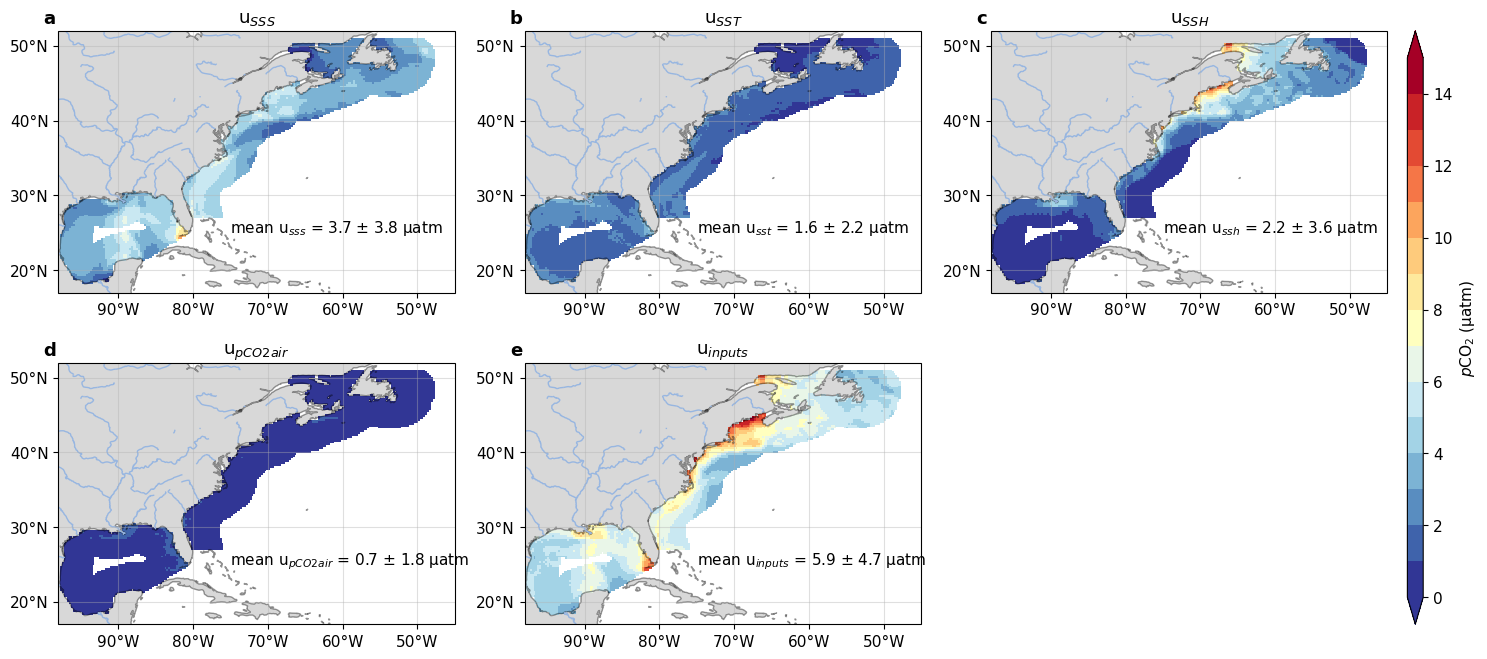

In [306]:
fig=plt.figure(figsize=(15,7))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2,3),
                axes_pad=(0.7,0.7),
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='2%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    if i < 5:
        ax.coastlines(alpha=0.4)
        ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
        ax.add_feature(cfeature.RIVERS)
        ax.set_xticks(np.arange(-180,181, 10), crs=projection)
        ax.set_yticks(np.arange(20,66, 10), crs=projection)

        ax.grid('on',alpha=0.4)
        lon_formatter = LongitudeFormatter()
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_xlim([-98,-45])
        ax.set_ylim([17,52])

        # ax.plot([-80.5,-87],[25,21],c='k',linewidth=1.5) # GoMx & CbS
        # ax.plot([-80.5,-77],[27,27],c='k',linewidth=1.5) # CbS & SAB
        # ax.plot([-76,-72],[35.5,35.5],c='k',linewidth=1.5) # SAB & MAB
        # ax.plot([-70,-70],[41.5,38.5],c='k',linewidth=1.5) # MAB & SS
        # ax.plot([-65.6,-65.6],[41,45],c='k',linewidth=1.5) # SS & GoMa
        # ax.plot([-60,-60],[42,45.5],c='k',linewidth=1.5) # SS & GStL

        # ax.text(-58,42,'GStL&GB') 
        # ax.text(-62.5,39.5,'SS') 
        # ax.text(-71,45,'GoMe') 
        # ax.text(-76,42,'MAB') 
        # ax.text(-76,30,'SAB') 
        # ax.text(-92,25,'GoMx') 
    if i == 0:
        p0 = ax.pcolor(lon_product,lat_product,np.nanmean(u_sss,axis=(0,1))*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdYlBu_r',15),clim=[0,15])
        ax.text(-75,25,'mean u$_{sss}$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(u_sss),np.nanstd(u_sss)))
        ax.set_title('u$_{SSS}$',)
    if i == 1:
        p1 = ax.pcolor(lon_product,lat_product,np.nanmean(u_sst,axis=(0,1))*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdYlBu_r',15),clim=[0,15])
        a = np.nanmean(np.nanmean(pco2_product_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        ax.text(-75,25,'mean u$_{sst}$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(u_sst),np.nanstd(u_sst)))
        ax.set_title('u$_{SST}$',)
    if i == 2:
        p2 = ax.pcolor(lon_product,lat_product,np.nanmean(u_ssh,axis=(0,1))*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdYlBu_r',15),clim=[0,15])
        a = np.nanmean(np.nanmean(pco2_product_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        ax.text(-75,25,'mean u$_{ssh}$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(u_ssh),np.nanstd(u_ssh)))
        ax.set_title('u$_{SSH}$',)
    if i == 3:
        p3 = ax.pcolor(lon_product,lat_product,np.nanmean(u_pco2air,axis=(0,1))*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdYlBu_r',15),clim=[0,15])
        a = np.nanmean(np.nanmean(pco2_product_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        ax.text(-75,25,'mean u$_{pCO2air}$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(u_pco2air),np.nanstd(u_pco2air)))
        ax.set_title('u$_{pCO2air}$',)
    if i == 4:
        p3 = ax.pcolor(lon_product,lat_product,np.nanmean(u_inputs,axis=(0,1))*mask_wide['mask_Atlantic'][0], transform=projection,cmap=plt.get_cmap('RdYlBu_r',15),clim=[0,15])
        a = np.nanmean(np.nanmean(pco2_product_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        ax.text(-75,25,'mean u$_{inputs}$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(u_inputs),np.nanstd(u_inputs)))
        ax.set_title('u$_{inputs}$',)
    if i == 5:
        ax.axis('off')
    # a = np.nanmean(np.nanmean(bias,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
    
    if i < 5:
        ax.text(-100,53,chr(97+i),fontdict={'size':13,'weight':'bold'})
cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$p$CO$_2$ (µatm)')
# cb0.set_ticks(np.arange(310,411,20))
plt.tight_layout()
plt.savefig('figures/Figure_B1.jpg',dpi=600)
plt.savefig('figures/Figure_B1.pdf',)
plt.show()

In [307]:
u_all_3d = u_all.reshape(fco2_socat.shape)
ds = xr.Dataset(
    data_vars=dict(
        # fco2_product_re =(["time", "lat", "lon"], fco2_product_calib),
        err =(["time", "lat", "lon"], u_all_3d),
        fco2_product =(["time", "lat", "lon"], fco2_product),
        pco2_product =(["time", "lat", "lon"], pco2_product),
    ),
    coords=dict(
        time=(["time"], time_socat),
        lat=(["lat"], lat_socat),
        lon=(["lon"], lon_socat),
    ),
    attrs=dict(description="Reconstructed fCO2 and pCO2"),
)
ds.to_netcdf('/Volumes/Crucial_4T/carbon/ReCAD/ReCAD-NAC-pCO2_with_err_v1.1.nc')